In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#style.use(('ggplot', 'seaborn-muted'))
style.use('seaborn-muted')
rc("image",cmap='gray',aspect='equal',interpolation='nearest')
rc("figure", figsize=(13,8))
#rc('font',family='ubuntu')

#from __future__ import division

In [3]:
from scipy import ndimage as ndi

In [4]:
from numba import jit

In [5]:
from tqdm.auto import tqdm

In [6]:
from imfun import ui

/home/brazhe/proj/image-funcut/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


Can't load OpenCV python bindings No module named 'cv2'
Can't load imreg package, affine and homography registrations won't work


In [7]:
logfn = log2

def jmax(M):
    "Max Jensen-Shannon divergence in a system of M states"
    #return -0.5*((M+1)*logfn(M+1)/M -2*logfn(2*M) + logfn(M))
    return -0.5*((M+1)*logfn(M+1)/M -logfn(4*M))


def shannon(P):
    "Shannon entropy for distribution {P}"
    return -np.sum(P[P>0]*logfn(P[P>0]))
 

def cecp(P):
    "cecp: calculate complexity-entropy causality pair for distribution {P}"
    M = len(P)
    Pe = np.ones(M)/M
    Sp = shannon(P)
    Smax = logfn(M)
    J = shannon(0.5*(P+Pe)) - 0.5*(Sp + Smax)
    Hr = Sp/Smax
    Cr = (J/jmax(M))*Hr
    return (Hr,Cr)

In [8]:
from skimage import filters as skfilters
from skimage import feature as skf
from skimage import color as skcolor

import itertools as itt

def hessian_by_dog(img, sigma):
    ndim = np.ndim(img)
    ax_pairs = itt.combinations_with_replacement(range(ndim),2)
    sigma = sigma/np.sqrt(2)
    trunc = 6 # default
    if sigma*trunc < 3:
        trunc = 3/sigma
    def dog(m,k):
        o = np.zeros(ndim, np.int)
        o[k] = 1
        return ndi.gaussian_filter(m, sigma, order=o, truncate=trunc)
    double_dog = lambda axp: dog(dog(img, axp[0]),axp[1])
    out = [double_dog(axp) for axp in ax_pairs]
    return out
    
def hessian_eigen_decomp(H):
    Hmat = skf.corner._hessian_matrix_image(H)
    w,v = eigh(Hmat)
    return w,v
               
               
def sato3d(img, sigma, 
           gamma12=0.5, gamma23=0.5, alpha=0.25, 
           hessian_variant='gradient_of_smoothed', 
           mode='nearest',
           return_vectors=False,
          ):
    if hessian_variant.lower() == 'dog':
        H = hessian_by_dog(img, sigma,mode=mode)
    elif hessian_variant.lower() == 'gradient_of_smoothed':
        H = skf.hessian_matrix(img, sigma, mode=mode)
    else:
        print('Unknown Hessian variant')
        return
    Hmat = skf.corner._hessian_matrix_image(H)
    #w = eigvalsh(Hmat)
    w,v = eigh(Hmat) # both vectors and values
    w = w[...,::-1]
    v = v[...,::-1]
    
    sh = img.shape
    out = np.zeros(sh)
    
    S = (np.sum(w**2,axis=-1))**0.5
    gamma = np.max(S)/2
    gamma_sq = 2*gamma**2
    
    lam1,lam2,lam3 = [w[...,i] for i in range(3)]
    
    ratio1 = np.where(lam3!=0,lam2/lam3,0)
    ratio2 = lam1/(1e-6 + np.abs(lam2))
    
    #ratio1 = np.abs(ratio1)
    #ratio2 = np.abs(ratio2)
    
    out = np.where(lam1 < 0, np.abs(lam3)*np.abs(ratio1)**gamma23*np.abs(1 + ratio2)**gamma12,
                np.where((lam2 < 0) & (lam1 < np.abs(lam2)/alpha), np.abs(lam3)*np.abs(ratio1)**gamma23*np.abs(1 - alpha*ratio2)**gamma12,0))
    #out = out*(1-exp(-S**2/gamma_sq))
    if return_vectors:
        return out, v
    else:
        return out

def sato2d(img, sigma, gamma12=0.5, alpha=0.25, hessian_variant='gradient_of_smoothed',return_vectors=False):
    if hessian_variant.lower() == 'dog':
        H = hessian_by_dog(img, sigma)
    elif hessian_variant.lower() == 'gradient_of_smoothed':
        H = skf.hessian_matrix(img, sigma,mode='nearest')
    else:
        print("unknown hessian variant")
        return
    Hmat = skf.corner._hessian_matrix_image(H)
    w,v = eigh(Hmat) # both eigenvectors and eigenvalues (in ascending order)
    w = w[...,::-1]  # flip to descending order
    v = v[...,::-1]  # flip to descending order
    
    sh = img.shape
    out = np.zeros(sh)

    # here lam1 >= lam2
    lam1,lam2 = [w[...,i] for i in range(2)]
    
    ratio2 = lam1/(1e-6 + np.abs(lam2))
    
    out = np.where(lam1 < 0, 
                   np.abs(lam2)*np.abs(1 + ratio2)**gamma12,
                   np.where((lam2 < 0) & (lam1 < np.abs(lam2)/alpha), np.abs(lam2)*np.abs(1 - alpha*ratio2)**gamma12,0))
    if return_vectors:
        return out, v
    else:
        return out   

In [9]:
@jit
def cartesian_to_polar(x,y):
    r = (x**2 + y**2)**0.5
    phi = arctan2(x,y)
    return r, phi

In [10]:
def percentile_rescale(stack, low=0.5, high=99.95):
    px = percentile(stack[stack>0],(low, high))
    return clip((stack-px[0])/(px[1]-px[0]), 0,1)

In [11]:
@jit
def corrupt_ppixels(img,p=0.1):
    nrows,ncols = img.shape
    Npx = nrows*ncols
    Ncorrupt = int(round(Npx*p))
    #rr = uniform(nrows,size=Ncorrupt).astype(int)
    #cc = uniform(ncols,size=Ncorrupt).astype(int)
    imgc = img.copy()
    for r in range(nrows):
        for c in range(ncols):
            if uniform() < p:
                imgc[r,c] = uniform()
    return imgc

In [12]:
@jit
def make_grid_pattern(size=512,freq=0.05,incl=0.5, rectify=True):
    sh = size,size
    out = np.zeros(sh)
    for r in range(size):
        for c in range(size):
            out[r,c] = sin(2*pi*(incl*freq*c + (1-incl)*freq*r))
    if rectify:
        out = np.maximum(out, 0)
    return out

CPU times: user 338 ms, sys: 28.9 ms, total: 367 ms
Wall time: 370 ms


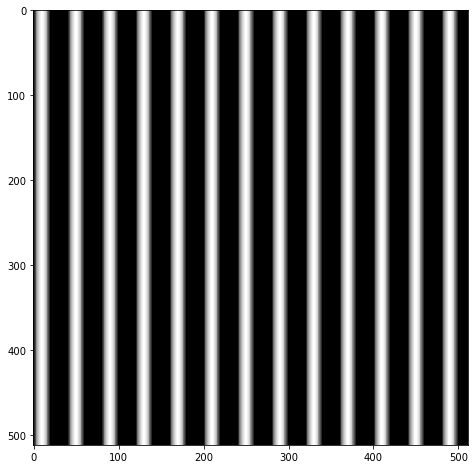

In [13]:
%time x = make_grid_pattern(512,freq=0.025,incl=1)
imshow(x)

In [14]:
incl_v = linspace(0,1,20)
stripes_angles = [make_grid_pattern(512, freq=0.025,incl=i) for i in incl_v]

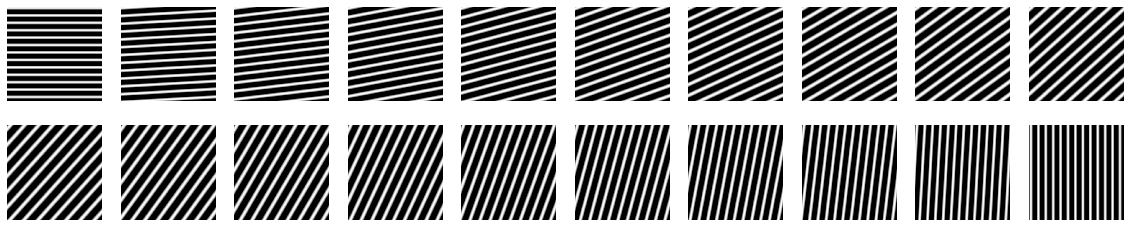

In [15]:
ui.group_maps(stripes_angles, colorbar=False)

In [16]:
img = stripes_angles[10]#[::-1]
img_noisy = img**1.5 + 0.01*randn(*img.shape)

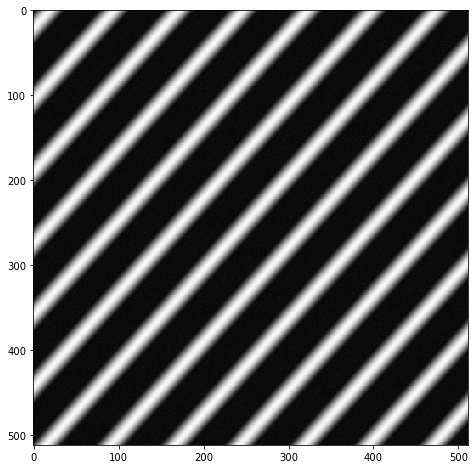

In [17]:
imshow(img_noisy)

In [18]:
H = skf.hessian_matrix(-img_noisy, 3, mode='nearest')
Hmat = skf.corner._hessian_matrix_image(H)

In [19]:
w,v = eigh(Hmat)

In [20]:
all(w[...,1] >= w[...,0])

True

In [21]:
all(abs(w[...,1]) >= abs(w[...,0]))

False

In [22]:
sato, vf = sato2d(img_noisy, 3, hessian_variant='gradient_of_smoothed', return_vectors=True)
#sato, vf = sato2d(img_noisy, 1.5, hessian_variant='dog', return_vectors=True)

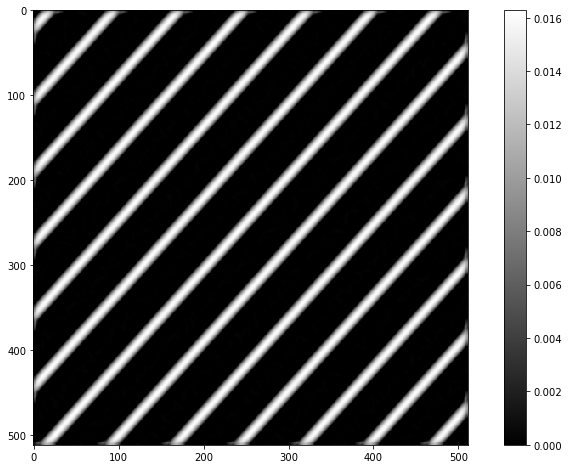

In [23]:

imshow(sato); colorbar()
#contour(sato, levels=[percentile(sato, 95)],colors='r')

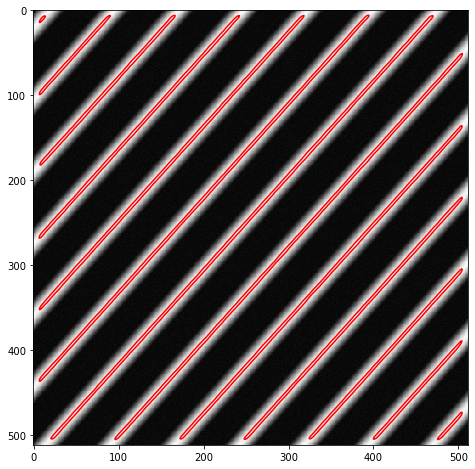

In [24]:
imshow(img_noisy)
#imshow(sato, cmap='plasma', alpha=0.5); colorbar()
contour(sato, levels=[percentile(sato, 95)],colors='r')

In [25]:
def cartesian_to_polar_field(V, do_flip=False, verbose=True):
    sh = V.shape
    out = np.zeros_like(V)
    for i in tqdm(range(sh[0]), disable=not verbose):
        for j in range(sh[1]):
            for n in range(sh[3]):
                xy = V[i,j,:,n]
                if do_flip:
                    xy = xy[::-1]
                out[i,j,:,n] = cartesian_to_polar(*xy)
    return out

In [26]:
%time vfp = cartesian_to_polar_field(vf, do_flip=False)


CPU times: user 1.95 s, sys: 181 µs, total: 1.95 s
Wall time: 1.94 s


In [27]:
vf.shape

(512, 512, 2, 2)

In [28]:
%time _,angles = (cartesian_to_polar(vf[...,0,:],vf[...,1,:]))

CPU times: user 317 ms, sys: 0 ns, total: 317 ms
Wall time: 316 ms


In [29]:
angles.shape

(512, 512, 2)

In [30]:
vfp.shape

(512, 512, 2, 2)

In [31]:
j = 0
phi = angles[...,j]

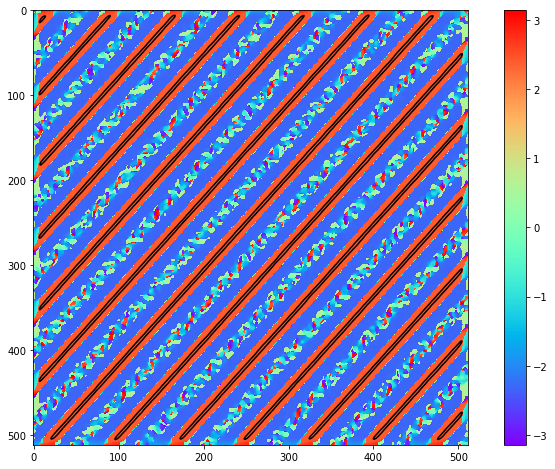

In [32]:
imshow(phi, cmap=cm.rainbow);colorbar()
contour(sato, levels=[percentile(sato, 95)],colors='k')

In [33]:
sato_n = percentile_rescale(sato)

In [34]:
phi2 = where(phi < 0, pi+phi, phi)

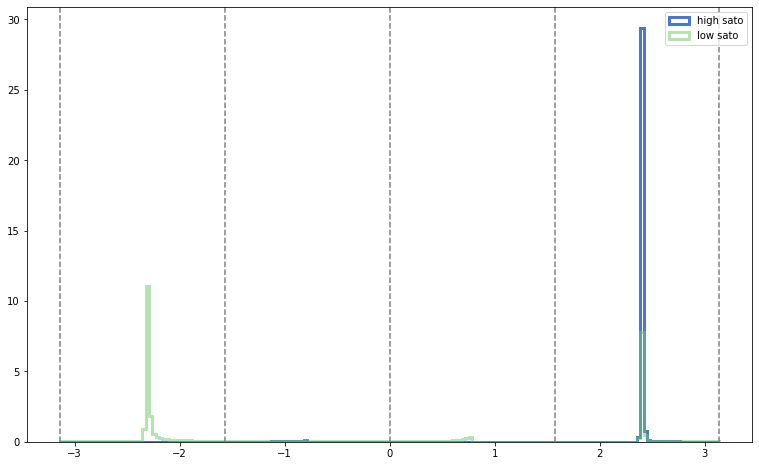

In [35]:
hist(ravel(phi),200, density=True, weights=ravel(sato_n),histtype='step',lw=3,label='high sato');
hist(ravel(phi),200, density=True, weights=np.max(sato_n)-ravel(sato),histtype='step',lw=3,label='low sato',alpha=0.5);
legend()
for a in (-pi, -pi/2, 0, pi/2, pi):
    axvline(a, color='gray', ls='--')

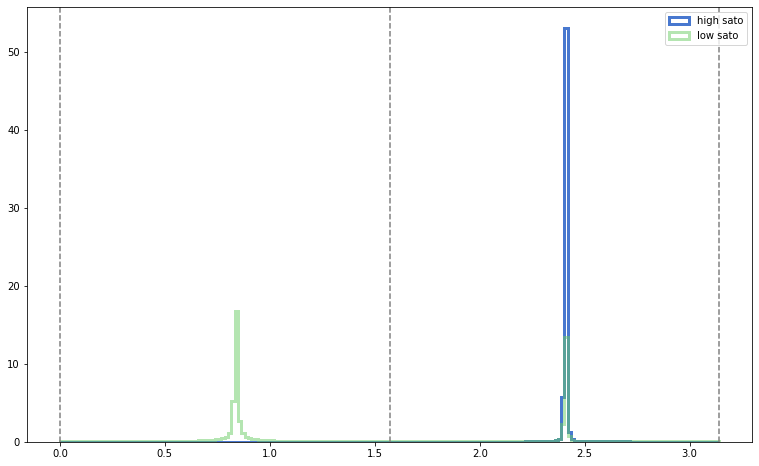

In [36]:
hist(ravel(phi2),200, density=True, weights=ravel(sato_n),histtype='step',lw=3,label='high sato');
hist(ravel(phi2),200, density=True, weights=np.max(sato_n)-ravel(sato),histtype='step',lw=3,label='low sato',alpha=0.5);
legend()
for a in ( 0, pi/2, pi):
    axvline(a, color='gray', ls='--')

In [37]:
hx,_ = np.histogram(ravel(phi2),200,weights=ravel(sato_n),density=False)
hx2,_ = np.histogram(ravel(phi2),200,weights=1-ravel(sato_n),density=False)

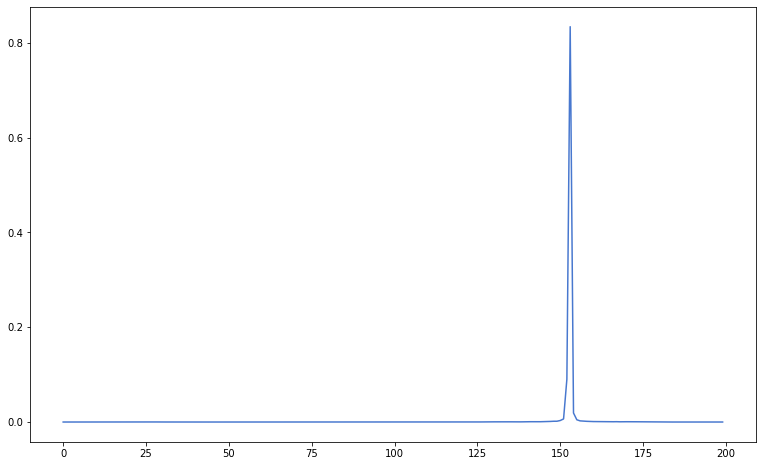

In [38]:
plot(hx/hx.sum())

In [45]:
def hessian_cecp2d(img, sigma, nbins=200, hessian_variant='gradient_of_smoothed', j=0, gamma=1, reverse_weights=False):
    sato, vf = sato2d(img, sigma, hessian_variant=hessian_variant, return_vectors=True)
    sato_n = percentile_rescale(sato, 0.1, 99.9)
    if reverse_weights:
        sato_n = 1-sato_n
    #_,angles = cartesian_to_polar(vf[...,0,:],vf[...,1,:])
    _,angles = cartesian_to_polar(vf[...,0,j],vf[...,1,j])
    #phi = angles[...,j]
    phi = angles
    phi2 = where(phi < 0, pi+phi, phi)
    hx,_ = np.histogram(ravel(phi2)**gamma, nbins, weights=ravel(sato_n))
    return cecp(hx/np.sum(hx))

In [46]:
cecps_sigma3 = array([hessian_cecp2d(img + 0.01*randn(*img.shape),3,gamma=2) for img in  tqdm(stripes_angles)])

In [47]:
sigmas = [0.75, 1.5, 3, 6]

cecps_stripes = [array([hessian_cecp2d(img + 0.01*randn(*img.shape), sigma, gamma=2) 
                        for img in  tqdm(stripes_angles)]) 
                 for sigma in tqdm(sigmas)]

In [48]:
def get_lower_envelope(N=200,step=0.01):
    # looks fine
    acc = []
    for p in arange(0,1+0.1*step,step):
        d = zeros(N)
        d[0] = p
        d[1:] = (1-p)/(N-1)
        acc.append(cecp(d))
    return np.array(acc)
    
def get_higher_envelope(N=200,step=1,verbose=False):
    "doesn't work..."
    acc = []
    for ncut in tqdm(range(1,N,step), disable=not verbose):
        p = zeros(N)
        p[:ncut] = 1/(ncut)
        acc.append(cecp(p))
    return np.array(acc)

def get_cecp_envelope(N,step_lower=0.01, step_upper=1):
    lower = get_lower_envelope(N,step_lower)
    upper = get_higher_envelope(N,step_upper)
    return np.vstack((lower,upper))

def test_powerlaw_distributions(N=200,alpha_range=linspace(-100,100,10000)):
    acc = []
    for alpha in alpha_range:
        p = linspace(1,N+1,N)**alpha
        acc.append(cecp(p/np.sum(p)))
    return array(acc)

In [49]:
%time hc_power = test_powerlaw_distributions()

CPU times: user 968 ms, sys: 26.2 ms, total: 994 ms
Wall time: 944 ms


In [50]:
#%time hc_low = get_lower_envelope()
#%time hc_high = get_higher_envelope()

%time cecp_env = get_cecp_envelope(200)
#%time hc_high2 = get_higher_envelope(int(1e5), step=10, verbose=True)
#%time hc_high3 = get_higher_envelope(int(1e6), step=1000, verbose=True)

CPU times: user 15.8 ms, sys: 0 ns, total: 15.8 ms
Wall time: 14.2 ms


In [51]:
h,c = cecp(hx/sum(hx))
ho,co = cecp(hx2/sum(hx2))

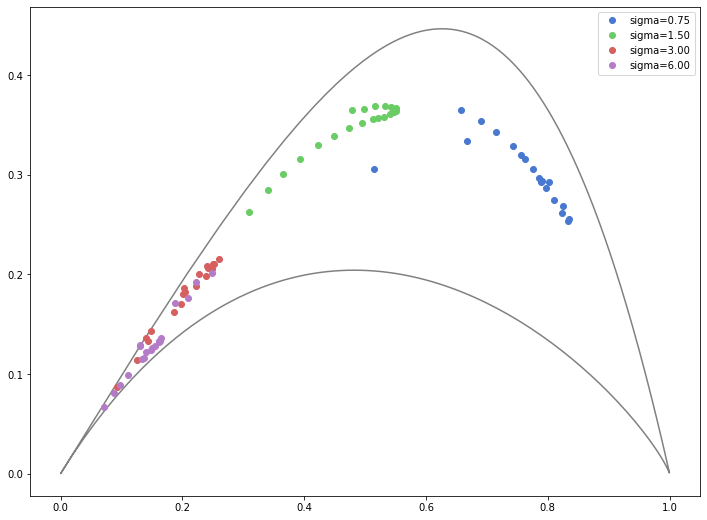

In [52]:
figure(figsize=(12,9))
#plot(hc_low[:,0],hc_low[:,1],'gray')
#plot(hc_high[:,0],hc_high[:,1],'gray')
plot(cecp_env[:,0],cecp_env[:,1],'gray')
#plot(hc_power[:,0],hc_power[:,1],color='teal', ls=':')

#plot(hc_high2[:,0],hc_high2[:,1],'gray',ls='--')
#plot(hc_high3[:,0],hc_high3[:,1],'gray',ls=':')

for k, s in enumerate(sigmas):
    x = cecps_stripes[k]
    plot(x[:,0],x[:,1], 'o', label='sigma=%1.2f'%s)
legend()

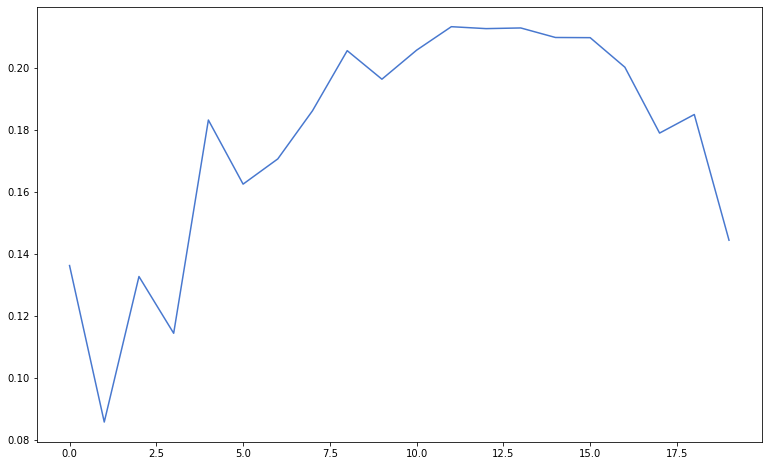

In [53]:
plot(cecps_sigma3[:,1])

In [54]:
pjitter = linspace(0,1,51)
#%time cxx = [corrupt_ppixels(make_grid_pattern(512, 0.03),p) for p in pjitter]
%time cxx = [corrupt_ppixels(make_grid_pattern(280, 0.05),p) for p in tqdm(pjitter)]

<ipython-input-11-66d0feef0f34>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "corrupt_ppixels" failed type inference due to: No implementation of function Function(np.random.uniform) found for signature:
 
 >>> <unknown function>()
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload in function 'Random_binary_distribution.generic': File: numba/core/typing/randomdecl.py: Line 257.
     With argument(s): '()':
    Rejected as the implementation raised a specific error:
      TypeError: typer() missing 2 required positional arguments: 'a' and 'b'
  raised from /home/brazhe/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/typing/templates.py:399

During: resolving callee type: Function(np.random.uniform)
During: typing of call at <ipython-input-11-66d0feef0f34> (11)


File "<ipython-input-11-66d0feef0f34>", line 11:
def corrupt_ppixels(img,p=0.1):
    <source elided>
        for c



CPU times: user 15.8 s, sys: 24.1 ms, total: 15.9 s
Wall time: 15.9 s


In [55]:
import shearlexity as shlx

/home/brazhe/src/PyShearlets/FFST/_fft.py:52: UserWarning: pyFFTW not found.  will try to use mklfft instead.
  warnings.warn("pyFFTW not found.  will try to use mklfft instead.")
/home/brazhe/src/PyShearlets/FFST/_fft.py:64: UserWarning: neither pyFFTW or mklfft found.  will use numpy.fft.
  warnings.warn("neither pyFFTW or mklfft found.  will use numpy.fft.")


In [56]:
#shlx.local_cecp()

In [57]:
#sl = (slice(10,-10),slice(10,-10))

In [58]:
#ckw1 = dict(rho=3,with_plots=False)

In [59]:
#hcx2  = array([(h[sl].mean(),c[sl].mean()) for h,c in (shlx.local_cecp(img,2) for img in tqdm(cxx))])

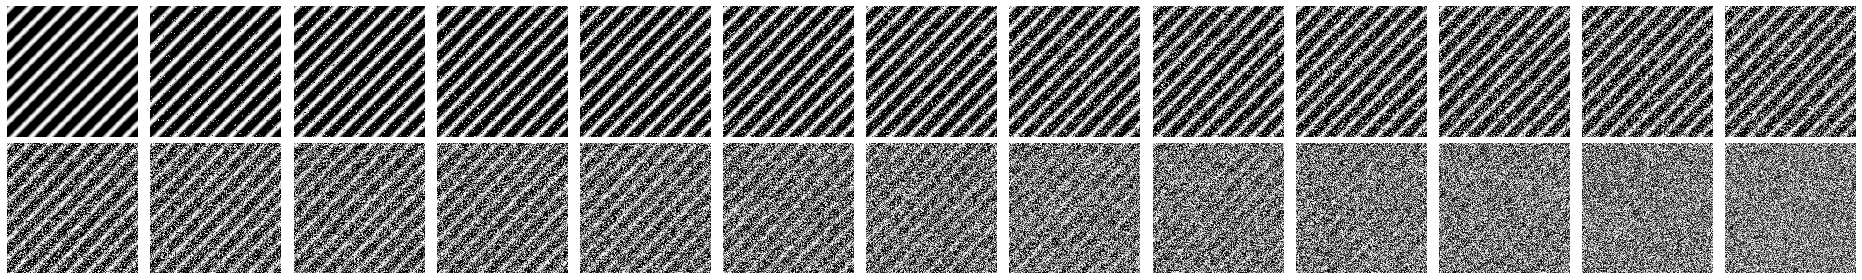

In [60]:
ui.group_maps(cxx[::2],13, colorbar=False)
tight_layout()

(0.3618237126950615, 0.29630934293059347)
(0.36183974216859766, 0.29631715138987014)
(0.3618237126950614, 0.29630934293059347)
(0.3618237126950614, 0.29630934293059347)


<Figure size 936x576 with 0 Axes>

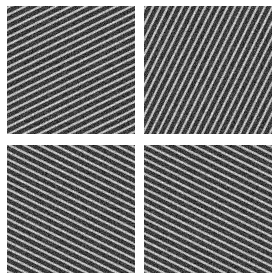

In [61]:
img =  make_grid_pattern(incl=0.33) + 0.1*randn(512,512)
figure()
ui.group_maps([img, img.T, img[::-1], img[:,::-1]], colorbar=False)
tight_layout()

print(hessian_cecp2d(img,3))
print(hessian_cecp2d(img.T,3))
print(hessian_cecp2d(img[::-1],3))
print(hessian_cecp2d(img[:,::-1],3))

In [62]:
hcx = [array([hessian_cecp2d(img, s, gamma=1) for img in (cxx)]) for s in tqdm(sigmas)]
hcx_rev = [array([hessian_cecp2d(img, s, gamma=1, reverse_weights=True) for img in (cxx)]) for s in tqdm(sigmas)]

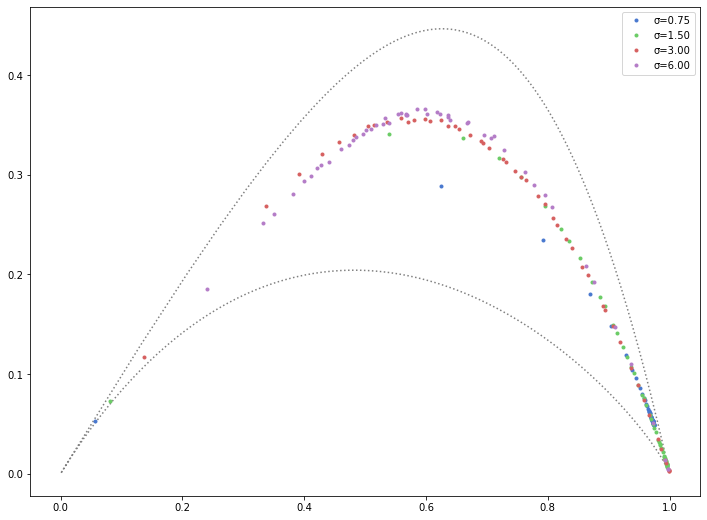

In [65]:
figure(figsize=(12,9))
plot(cecp_env[:,0],cecp_env[:,1],'gray',ls=':')

for k, s in enumerate(sigmas):
    plot(hcx[k][:,0],hcx[k][:,1],'.',label='σ=%1.2f'%s)
    #plot(hcx_rev[k][:,0],hcx_rev[k][:,1],'+',label='(-) σ=%1.2f'%s)
legend()

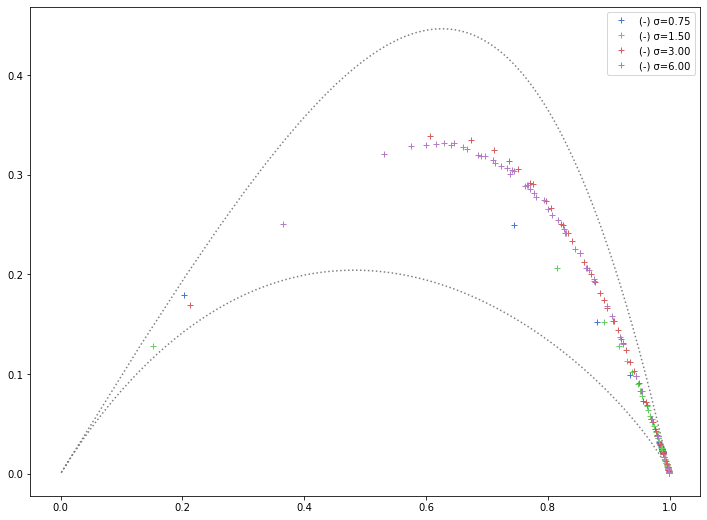

In [64]:
figure(figsize=(12,9))
plot(cecp_env[:,0],cecp_env[:,1],'gray', ls=':')

for k, s in enumerate(sigmas):
    #plot(hcx[k][:,0],hcx[k][:,1],'.',label='σ=%1.2f'%s)
    plot(hcx_rev[k][:,0],hcx_rev[k][:,1],'+',label='(-) σ=%1.2f'%s)
legend()

## **3D**

In [34]:
import napari

/home/brazhe/opt/anaconda3/envs/py38/lib/python3.8/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [35]:
%gui qt

In [36]:
def gaussian_blob(x,y, sigma_x, sigma_y):
    return np.exp(-x**2/(2*sigma_x**2) - y**2/(2*sigma_y**2))

X,Y = mgrid[:256,:256]

#sigma_r_v = logspace(-1, 1.6, 16, base=2)
sigma_r_v = ones(1000)

locs = arange(15,250,15)
print(len(locs))


centers = [(r,c) for r in locs for c in locs]

img_x = np.sum([gaussian_blob(X-r,Y-c, sigma_r, sigma_r) for (r,c),sigma_r in zip(centers, sigma_r_v)],0)

16


In [37]:
test_stack_clean =  np.array([img_x]*213)
test_stack = test_stack_clean + randn(*test_stack_clean.shape)*0.05

In [70]:
#test_stack = moveaxis(test_stack, 0, 1)
#test_stack = moveaxis(test_stack, 0, 2)
#test_stack = test_stack.T

In [71]:
test_stack.shape

(213, 256, 256)

In [72]:
#napari.view_image(test_stack, ndisplay=3)

In [73]:
%time sato, Vf = sato3d(test_stack, 3, return_vectors=True)

CPU times: user 33.1 s, sys: 5.26 s, total: 38.4 s
Wall time: 38.1 s


In [74]:
sato_n = percentile_rescale(sato, 0.1, 99.9)

In [75]:
@jit
def cartesian_to_polar3d(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = arctan2((x**2 + y**2)**0.5, z)
    phi = arctan2(y,x)
    return r, theta, phi


@jit
def polar_to_cartesian3d(r, theta, phi):
    x = r*sin(theta)*cos(phi)
    y = r*sin(theta)*sin(phi)
    z = r*cos(theta)
    
    return x,y,z


def flip_directions(alphas):
    return np.where(alphas < 0, alphas+pi, alphas)


In [76]:
Vf.shape

(213, 256, 256, 3, 3)

In [77]:
j = 0
Vfj = Vf[...,j]

In [78]:
x = arange(9).reshape(3,3)
x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [79]:
x[...,0]

array([0, 3, 6])

In [80]:
Vf.shape, Vfj.shape

((213, 256, 256, 3, 3), (213, 256, 256, 3))

In [81]:
#Vfjx = np.hstack([reshape(Vfj[...,i],(-1,1)) for i in range(3)])
#Vfjx.shape

In [82]:
#allclose(Vfjx, Vfj.reshape(-1,3))


In [83]:
%time u,s,vh = svd(Vfj.reshape(-1,3), full_matrices=False)

CPU times: user 2.52 s, sys: 3.34 s, total: 5.86 s
Wall time: 1.12 s


In [84]:
#%time rr,thetas,rhos = cartesian_to_polar3D(Vfj[...,0],Vfj[...,1],Vfj[...,2]) # x,y,z
%time rr,thetas,rhos = cartesian_to_polar3d(u[...,2],u[...,1],u[...,0]) # svd-vectors
#%time rr,thetas,rhos = cartesian_to_polar3D(Vf[...,0,:],Vf[...,1,:],Vf[...,2,:]) # x,y,z

CPU times: user 1.01 s, sys: 72.3 ms, total: 1.08 s
Wall time: 1.08 s


In [85]:
rr.min(), rr.max()

(0.0004139986885762169, 0.0006603106537028523)

In [86]:
thetas.shape

(13959168,)

In [87]:
thetas.min(), thetas.max()

(0.0001256137396702137, 3.1415227618812325)

In [88]:
rhos2 = flip_directions(rhos)

In [89]:
ravel(thetas).shape, ravel(sato_n).shape

((13959168,), (13959168,))

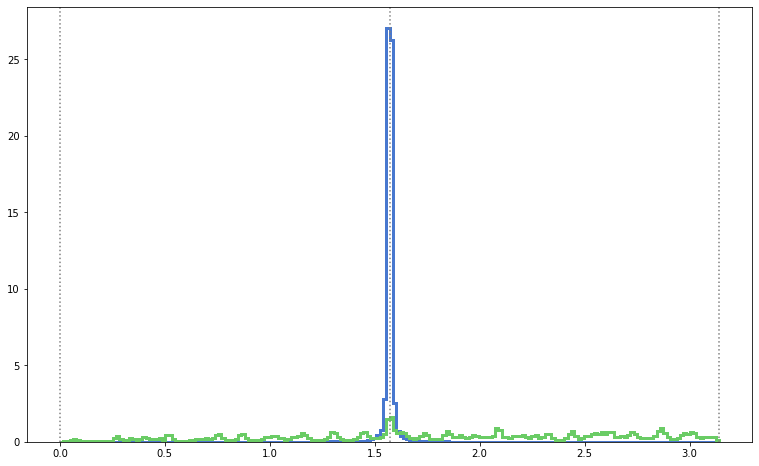

In [90]:
_ = hist(ravel(thetas), 200, weights=ravel(sato_n), density=True, histtype='step',lw=3)
_ = hist(ravel(thetas), 200, weights=1-ravel(sato_n), density=True, histtype='step',lw=3)

for a in (0,pi/2,pi):
    axvline(a, color='gray', ls=':')

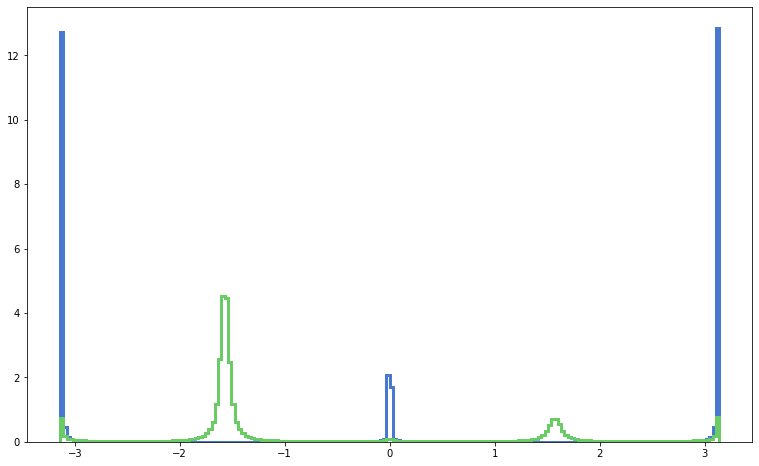

In [91]:
_ = hist(ravel(rhos), 200, weights=ravel(sato_n), density=True, histtype='step',lw=3)
_ = hist(ravel(rhos), 200, weights=1-ravel(sato_n), density=True, histtype='step',lw=3)

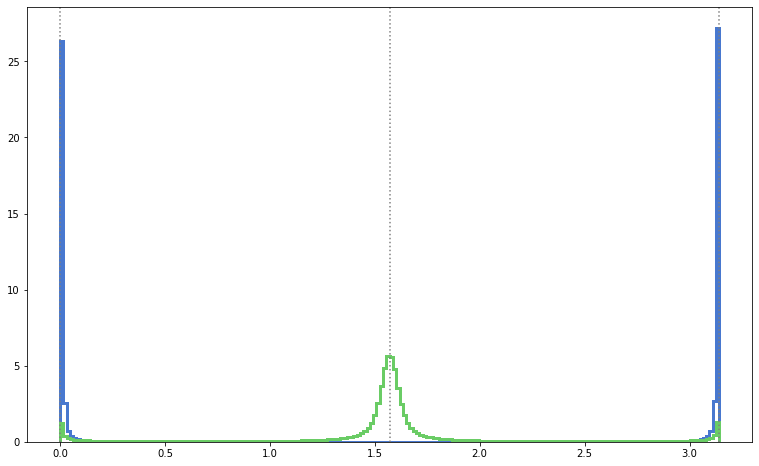

In [92]:
_ = hist(ravel(rhos2), 200, weights=ravel(sato_n), density=True, histtype='step',lw=3)
_ = hist(ravel(rhos2), 200, weights=1-ravel(sato_n), density=True, histtype='step',lw=3)
for a in (0,pi/2,pi):
    axvline(a, color='gray', ls=':')

In [93]:
H, xedges, yedges = np.histogram2d(ravel(thetas), (ravel(rhos2)),bins=(50,50), density=True, weights=ravel(sato_n))

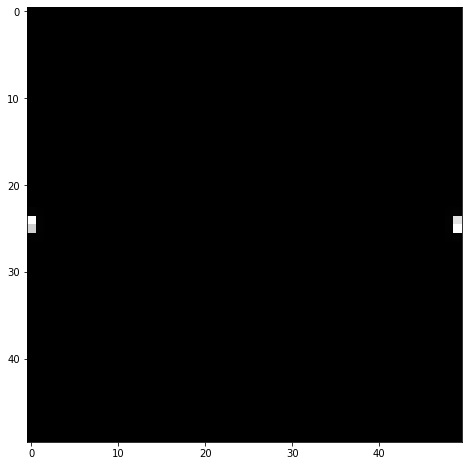

In [94]:
figure()
imshow(H)

In [95]:
cecp(ravel(H)/np.sum(H))

(0.2297567800255621, 0.21302532216320652)

In [96]:
#selected_points = Vf[sato_n <= 0.00][::1000]
selected_points = dot(u,diag(s))[ravel(sato_n) >= 0.99]

In [97]:
selected_points.shape

(11722, 3)

(-1.0, 1.0)

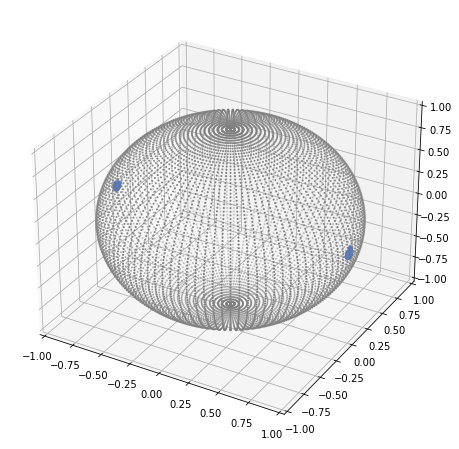

In [98]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')


theta, phi = meshgrid(linspace(0,pi,100), linspace(-pi,pi,100))
r = np.ones(theta.size)

x,y,z = polar_to_cartesian3d(r, ravel(theta), ravel(phi))

ax.scatter(x,y,z,s=1,color='gray')

ax.scatter(selected_points[:,2], selected_points[:,1], selected_points[:,0],s=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

## Краткий план дальше:
 - [X] Неопределенность второго угла возникает, если интересующие нас вектора смотрят на "полюса" относительно азимутального угла. Можно выбрать новую систему координат (SVD), в котором коллективное направление векторов будет указывать *не* на азимут, а на точку на "экваторе" относительно азимута. Это даст возможность использовать простую 2D гистограмму углов. Во всяком случае, это рабочая гипотеза
 - [ ] Дополнительные проверочные/тестовые данные
 - [-] Реализовать любой удобный способ размещения N точек на поверхности шара (Фибоначчи или что-то другое, не важно. Возможно, Евклидово тело)
 - [-] для точек взять проекции на вектора, соответствующие этим N точкам. Распределение проекций -- использовать для энтропии/сложности
 - [-] подумать об учете направления в обе стороны
 - [ ] глянуть oriented historgrams in 3D
 - [ ] глянуть что там делают в ImageJ аналогичного.

In [101]:
ndim((2,2))

1

In [102]:

def hessian_cecp3d(stack, sigma, 
                   nbins=50, 
                   hessian_variant='gradient_of_smoothed', 
                   j=0, 
                   gamma=1, 
                   reverse_weights=False,
                   with_plot=False):
    sato, Vf = sato3d(stack, sigma, hessian_variant=hessian_variant, return_vectors=True)
    sato_n = percentile_rescale(sato, 0.1, 99.9)
    if reverse_weights:
        sato_n = 1-sato_n
    #_,angles = cartesian_to_polar(vf[...,0],vf[...,1])
    Vfj = Vf[...,j] # first vectors point along bright tubular structures
    u,s,vh = svd(Vfj.reshape(-1,3), full_matrices=False) # find collective directions of the vectors and use the rotated projection
    rr,thetas,rhos = cartesian_to_polar3d(u[...,1],u[...,2],u[...,0]) # x,y,z
    rhos = flip_directions(rhos)
    #hx,_ = np.histogram(ravel(phi2)**gamma, nbins, weights=ravel(sato_n))
    hx, xedges, yedges = np.histogram2d(ravel(thetas), (ravel(rhos)),bins=(nbins,nbins), density=True, weights=ravel(sato_n))
    hx = ravel(hx)
    if with_plot:
        
        f,axs = subplots(1,2,sharex=True)
        axs[0].set_title('Theta')
        axs[1].set_title('Phi')
        _ = axs[0].hist(ravel(thetas), 200, weights=ravel(sato_n), density=True, histtype='step',lw=3,)
        _ = axs[1].hist(ravel(rhos), 200, weights=ravel(sato_n), density=True, histtype='step',lw=3,)
        
        selected_points = dot(u,diag(s))[ravel(sato_n) >= 0.99]
        N = len(selected_points)
        if N > 10000:
            selected_points = permutation(selected_points)[:10000]
        fig = plt.figure(figsize=(9,8))
        ax = fig.add_subplot(111, projection='3d')

        theta, phi = meshgrid(linspace(0,pi,100), linspace(-pi,pi,100))
        r = np.ones(theta.size)

        x,y,z = polar_to_cartesian3d(r, ravel(theta), ravel(phi))

        ax.scatter(x,y,z,s=1,color='gray',alpha=0.5)

        ax.scatter(selected_points[:,2], selected_points[:,1], selected_points[:,0],s=10,alpha=0.5)

        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        
        
        
    return cecp(hx/np.sum(hx))

CPU times: user 36.1 s, sys: 8.48 s, total: 44.5 s
Wall time: 39.4 s


(0.22975692927808564, 0.21302545462133735)

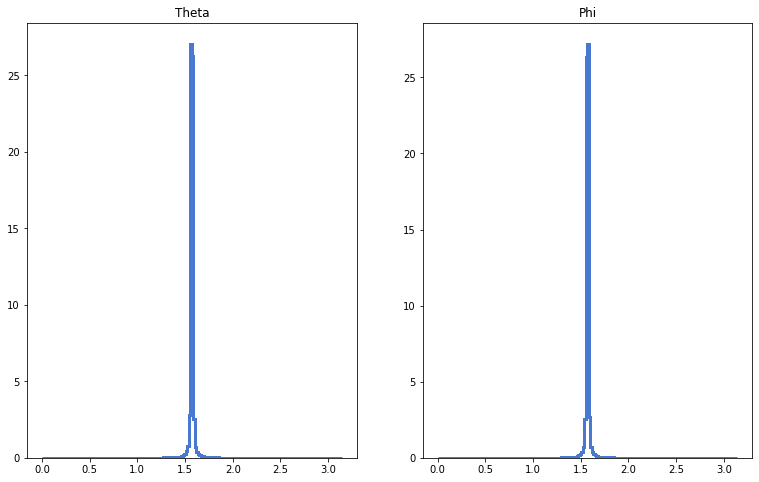

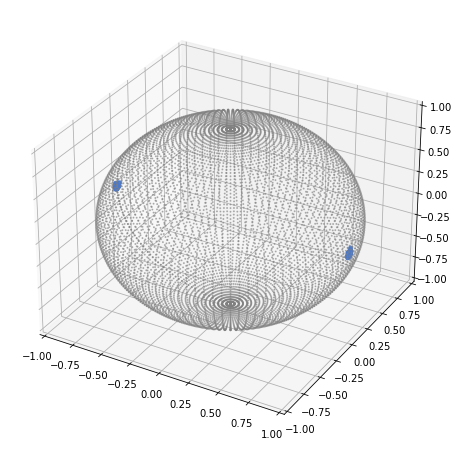

In [103]:
%time hc_in = hessian_cecp3d(test_stack, 3, with_plot=True,j=0)
hc_in

In [104]:
#hessian_cecp3d(trails_stack, 3, with_plot=True,j=-1)

CPU times: user 38 s, sys: 5.69 s, total: 43.7 s
Wall time: 37.8 s


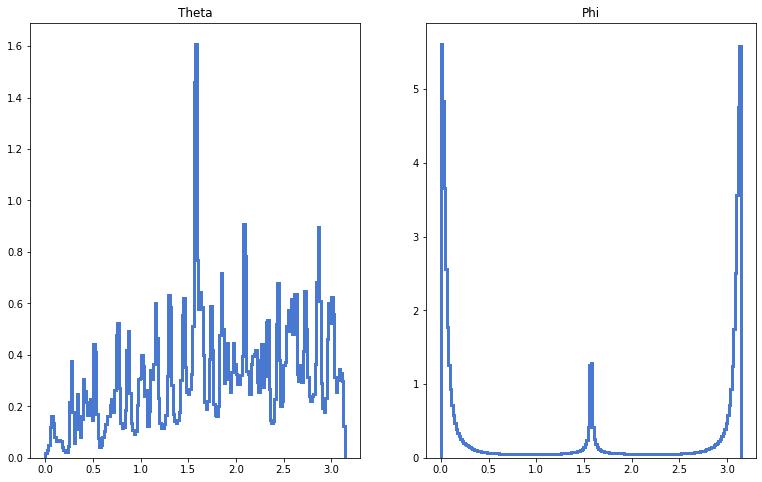

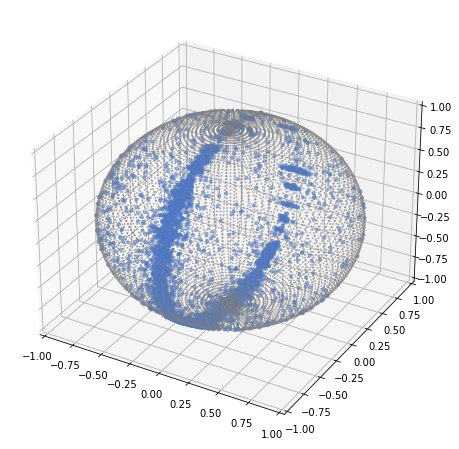

In [105]:
%time hc_out = hessian_cecp3d(test_stack, 3, reverse_weights=True, with_plot=True)

CPU times: user 30.9 s, sys: 5.39 s, total: 36.3 s
Wall time: 30.3 s


(0.23036829358409164, 0.21318267814566852)

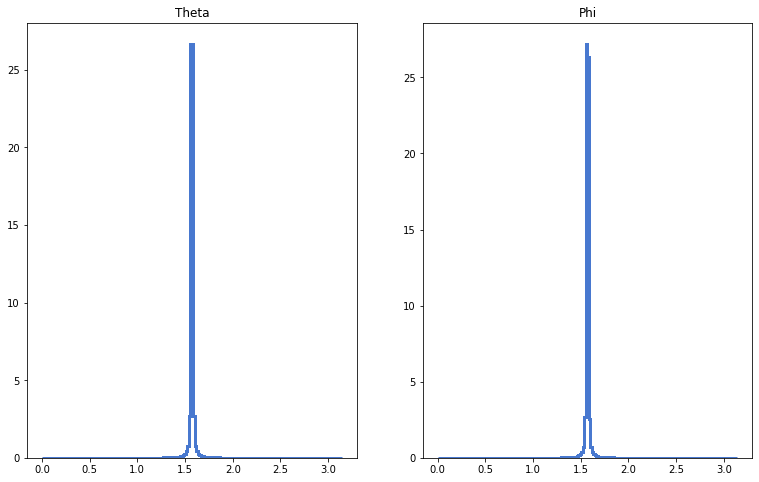

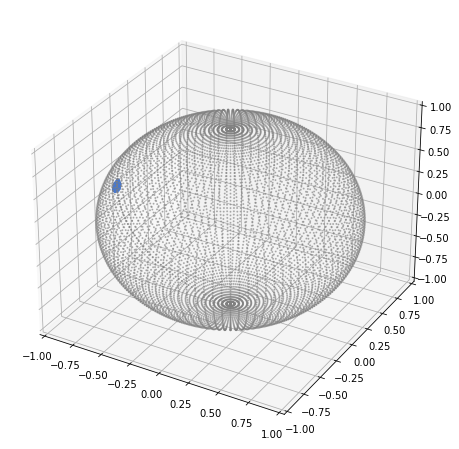

In [106]:
%time hc_in2 = hessian_cecp3d(test_stack.T, 3, with_plot=True)
hc_in2

CPU times: user 31 s, sys: 5.19 s, total: 36.2 s
Wall time: 30.3 s


(0.2302415098594809, 0.2131589163710089)

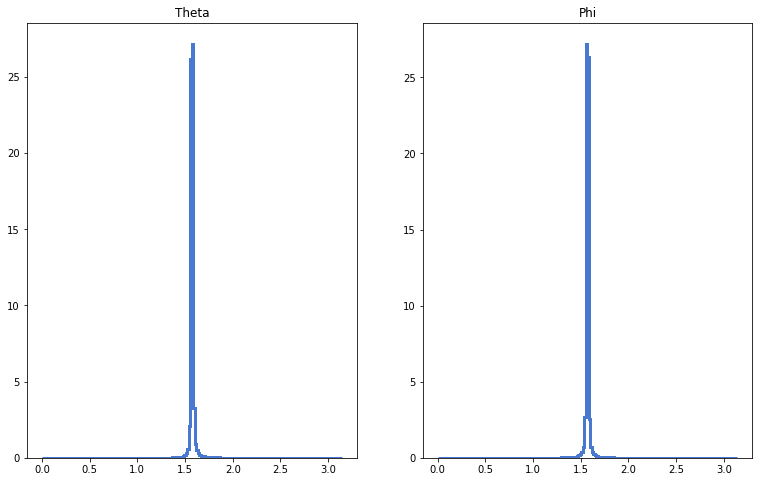

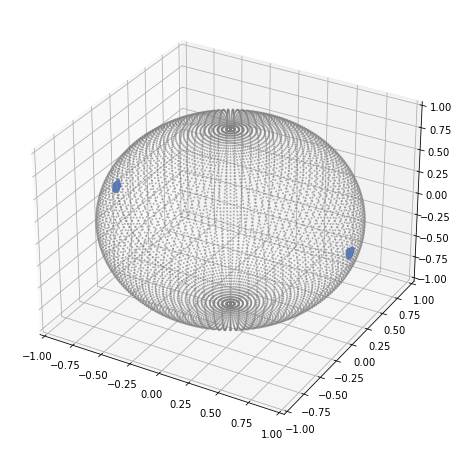

In [107]:
%time hc_in3 = hessian_cecp3d(moveaxis(test_stack, 0,1), 3,with_plot=True)
hc_in3

CPU times: user 31 s, sys: 4.86 s, total: 35.8 s
Wall time: 30 s


(0.23032246652617205, 0.2131831936454488)

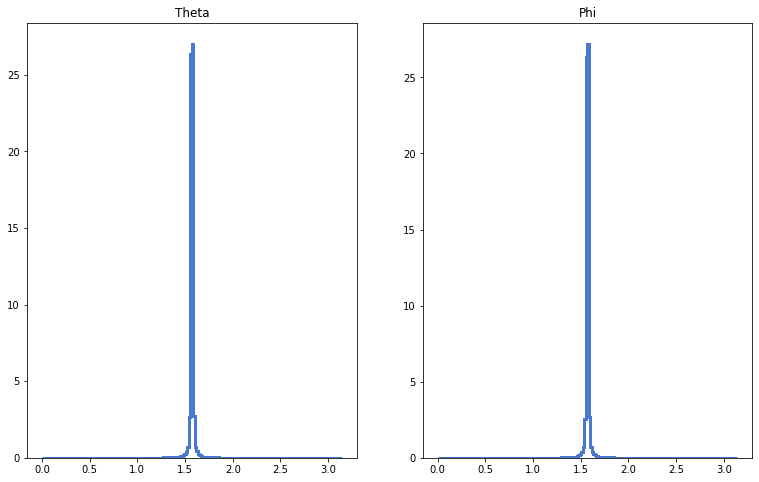

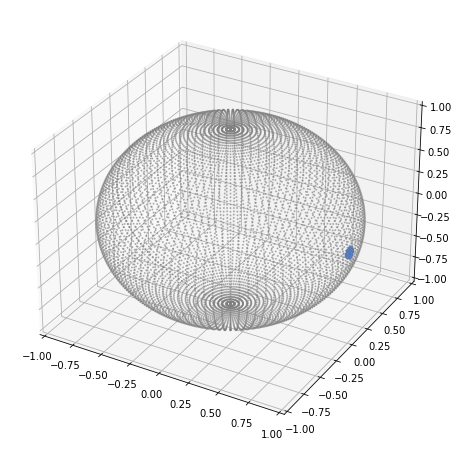

In [108]:
%time hc_in4 = hessian_cecp3d(moveaxis(test_stack, 0,2), 3,with_plot=True)
hc_in4

In [109]:
# %time hc_in5 = hessian_cecp3d(moveaxis(test_stack, 1,2), 3)
# hc_in5

In [110]:
test_stack_rot = ndi.rotate(test_stack_clean, 63)
test_stack_rot = test_stack_rot + randn(*test_stack_rot.shape)*0.05

In [111]:
#napari.view_image(test_stack_rot, ndisplay=3)

CPU times: user 1min, sys: 9.79 s, total: 1min 10s
Wall time: 1min 1s


(0.3581510209933431, 0.2597467601033785)

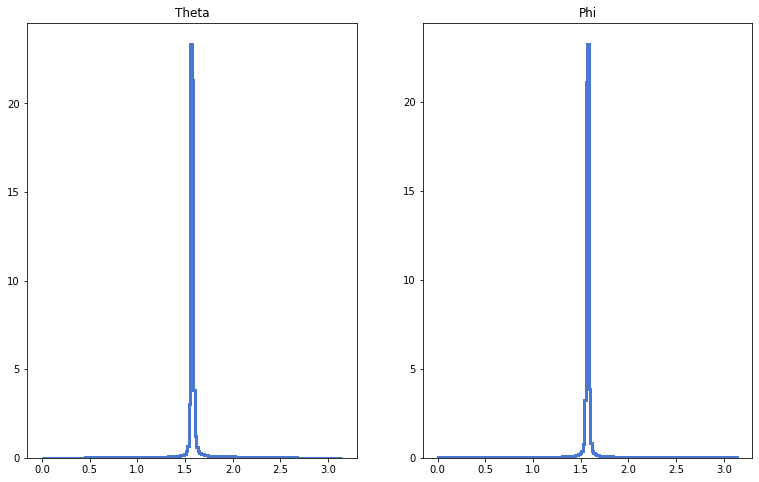

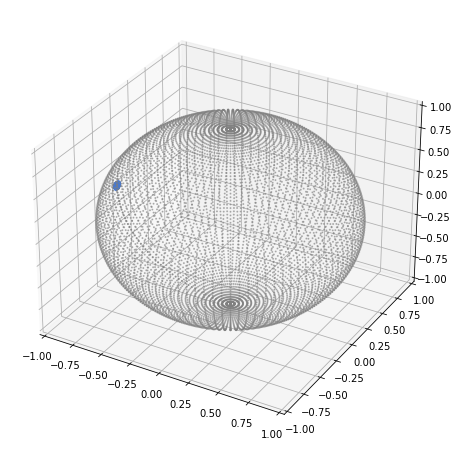

In [112]:
%time hc_in_rot = hessian_cecp3d(moveaxis(test_stack_rot, 1,2), 3, with_plot=True)
hc_in_rot

CPU times: user 34.2 s, sys: 4.91 s, total: 39.1 s
Wall time: 33.3 s


(0.9729905895484134, 0.0796686873896375)

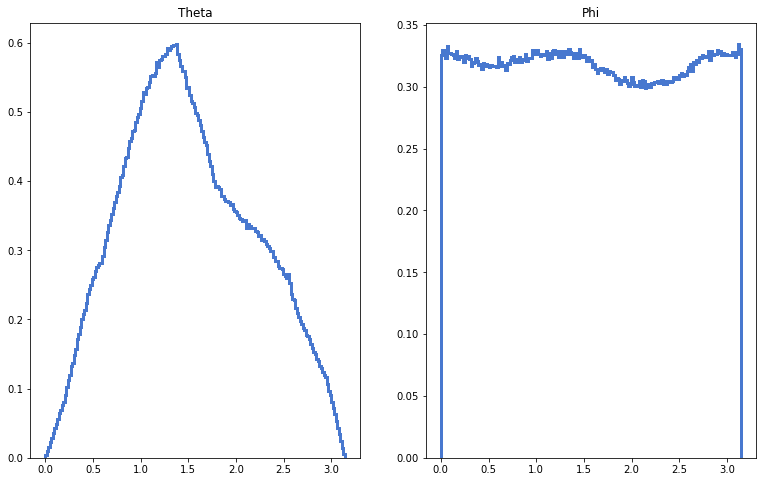

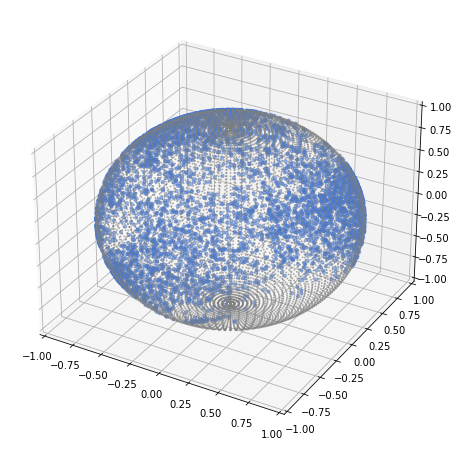

In [113]:
%time hc_noise = hessian_cecp3d(randn(*test_stack.shape), 3, with_plot=True)
hc_noise

In [114]:
hc_noise

(0.9729905895484134, 0.0796686873896375)

In [123]:
def make_caustic_stack(shape, sigma,niters=5):
    stack = randn(*shape)
    for i in tqdm(range(niters)):
        stack = sato3d(stack, sigma)
    return stack

In [122]:
%time stack_caustic = make_caustic_stack(test_stack.shape, 3)


CPU times: user 5min 43s, sys: 35.1 s, total: 6min 18s
Wall time: 6min 19s


In [128]:
napari.view_image(stack_caustic, ndisplay=3)

CPU times: user 33.1 s, sys: 5.85 s, total: 39 s
Wall time: 32.4 s


(0.972799650095962, 0.08187848703200017)

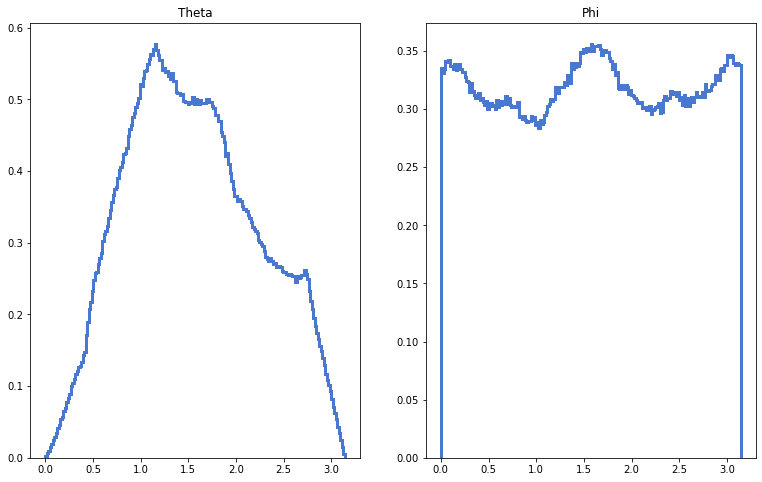

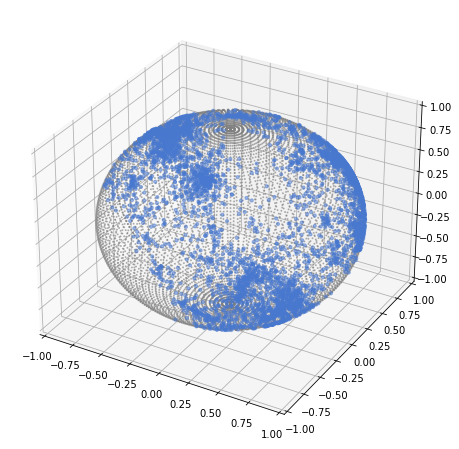

In [117]:
%time hc_caustic = hessian_cecp3d(stack_caustic, 3, with_plot=True)
hc_caustic

In [118]:
%time hc_env2 = get_cecp_envelope(50*50)

CPU times: user 258 ms, sys: 226 µs, total: 258 ms
Wall time: 257 ms


In [119]:
#hc_in_coll = array([hc_in, hc_in2, hc_in3, hc_in4, hc_in5])

Text(0, 0.5, 'C')

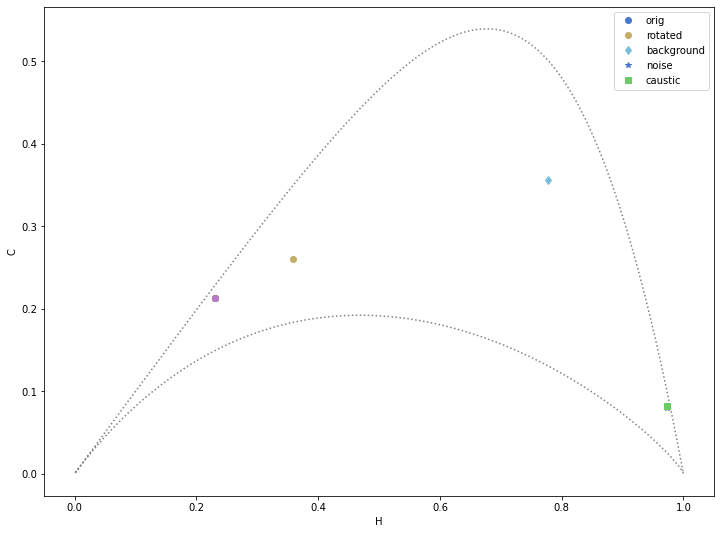

In [120]:
figure(figsize=(12,9))

plot(hc_env2[:,0],hc_env2[:,1], 'gray',ls=':')
plot(hc_in[0],hc_in[1],'o',label='orig')
plot(hc_in2[0],hc_in2[1],'o')
plot(hc_in3[0],hc_in3[1],'o')
plot(hc_in4[0],hc_in4[1],'o')
plot(hc_in_rot[0],hc_in_rot[1],'o',label='rotated')
plot(hc_out[0],hc_out[1],'d',label='background')
plot(hc_noise[0],hc_noise[1],'*',label='noise')
plot(hc_caustic[0],hc_caustic[1],'s',label='caustic')

legend()
xlabel("H")
ylabel('C')

In [130]:
import hessian_cecp as hcecp

In [131]:
import pandas as pd
def get_ms_complexity(stack, sigmas=(0.5, 1, 2, 4, 8, 16), patch_size=24, patch_overlap=None):
    out = {}
    if patch_overlap is None:
        patch_overlap = patch_size//2
    for s in tqdm(sigmas):
        hc_acc = hcecp.hessian_cecp3d(stack, s, spatial_binning=patch_size,spatial_overlap=patch_overlap)
        hc_mf = np.sum(hc_acc[:,:2]*hc_acc[:,2][:,None], axis=0)
        out[s] = hc_mf
    return pd.DataFrame(out, index=('h','c'))

In [132]:
%time res24 = get_ms_complexity(stack_caustic, patch_size=24)


CPU times: user 5min 33s, sys: 5.46 s, total: 5min 38s
Wall time: 5min 38s


In [143]:
sigmas_new = np.round(logspace(-1,4,12, base=2),3)

In [145]:
patch_sizes = (12, 16, 24, 32, 48, 64)

In [146]:
res_caustic = {ps: get_ms_complexity(stack_caustic, sigmas_new, ps) for ps in tqdm(patch_sizes)}

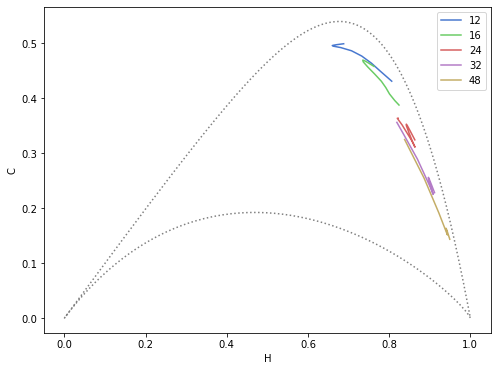

In [152]:
f,ax =  subplots(1,1,figsize=(8,6))
hcecp.prep_hc_axes(50*50, ax=ax)

for ps in patch_sizes:
    res =  res_caustic[ps]
    ax.plot(res.loc['h'],res.loc['c'],label=ps);

legend()
#ax.scatter(res24.loc['h'],res24.loc['c'],c=res24.columns,cmap='plasma');
#colorbar()

### Designing test structures in 3D 

**Basic idea:** random walkers evolve in 3D space  and leave trails (like turbosnails), which then can be smoothed out.

In [26]:
import hessian_cecp as hcecp

In [27]:
from importlib import reload
reload(hcecp)

<module 'hessian_cecp' from '/home/brazhe/yandex-disk/dev/notebooks/astrocyte-morphology-and-networks/hessian_cecp.py'>

In [28]:
import numba

@numba.jit
def make_trajectory3d(x0, force_field, xtrails, m=1, friction=0.1, T=100, dt=1,tol=0.001,gamma_speed=0.5,wrap_bounds=False):
    traj = np.zeros((T,) + (len(x0),))
    #print(traj.shape)
    
    nz,nr,nc,nd = force_field.shape
    
    F = force_field
    a0 = F[int(x0[0]),int(x0[1]),int(x0[2])]/m 
    #print(a0)
    traj[0] = x0
    traj[1] = x0 + a0*dt**2/2
    for i in range(1, T-1):
        z,r,c = traj[i]

        zi,ri,ci = np.int(z), np.int(r),np.int(c)
        if wrap_bounds:
            zi = zi%nz
            ri = ri%nr
            ci = ci%nc
        else:
            #zi = max(min(zi,nz-1),0)
            #ri = max(min(ri,nr-1),0)
            #ci = max(min(ci,nc-1),0)                            
            if zi >= nz or ri >= nr or c >= nc or z < 0 or r < 0 or c < 0:
                break
                
        speed = np.sum((traj[i]-traj[i-1])**2)**gamma_speed
        if speed < tol:
            break
        xtrails[zi,ri,ci] = xtrails[zi,ri,ci] + speed 
        a = F[zi,ri,ci]/m
        #print(a)
        traj[i+1] = (2-friction)*traj[i] - (1-friction)*traj[i-1] + a*dt**2
    return traj[:i]

In [32]:
def make_trails_stack(out_shape, Nparticles=100, sigma=1.5, field_mag=1, random_weight=0.5, drift=(1,1,1), with_progress=False):
    F = random_weight*np.random.randn(*(out_shape + (3,))) + (1-random_weight)*asarray(drift)
    F = F*field_mag
    trails = np.zeros(out_shape)
    starts = [tuple(randint(n) for n in trails.shape) for i in range(Nparticles)]
    for x0 in tqdm(starts, disable=not with_progress):
        make_trajectory3d(x0, F, trails, T=1000, dt=0.2, gamma_speed=0.01,wrap_bounds=True)
    #trails = percentile_rescale(trails)
    return percentile_rescale(ndi.gaussian_filter(trails, sigma)) + 0.05*randn(*out_shape)

@jit
def make_radial_drift(out_shape, x0):
    field = np.zeros(out_shape + (3,))
    nz, nr,nc = out_shape
    for z in range(nz):
        for r in range(nr):
            for c in range(nc):
                v = np.array((z,r,c)) - x0
                vnorm = np.sum(v**2)**0.5
                if vnorm > 0.001:                    
                    field[z,r,c] = v = v/vnorm
    return field

def nhood_slice(x0, nhood=3):
    return tuple(slice(x-nhood, x+nhood+1) for x in x0)
                    
def make_trails_stack2(out_shape, Nparticles=100, starts=None, sigma=1.5, field_mag=1, random_weight=0.5, drift=(1,1,1), with_progress=False):
    F = random_weight*np.random.randn(*(out_shape + (3,))) + (1-random_weight)*asarray(drift)
    F = F*field_mag
    trails = np.zeros(out_shape)
    if starts is None:
        starts = [tuple(randint(n) for n in trails.shape) for i in range(Nparticles)]
    for x0 in tqdm(starts, disable=not with_progress):
        make_trajectory3d(x0, F, trails, T=1000, dt=0.2, gamma_speed=0.01,wrap_bounds=False)
    #trails = percentile_rescale(trails)
    return percentile_rescale(ndi.gaussian_filter(trails, sigma)) + 0.05*randn(*out_shape)

In [38]:
x0 = array(test_stack.shape)//2

In [39]:
drift = make_radial_drift(test_stack.shape, x0)

In [40]:
starts = np.zeros(test_stack.shape, bool)
starts[nhood_slice(x0,2)] = 1
start_locs = [array(s) for s in (zip(*where(starts)))]

In [41]:
#napari.view_image(starts)

In [42]:
7*7*7

343

In [43]:
len(start_locs)

125

In [47]:
%time burst_stack = make_trails_stack2(test_stack.shape, starts=start_locs, drift=drift, random_weight=0.5)

CPU times: user 1.83 s, sys: 208 ms, total: 2.04 s
Wall time: 2.03 s


In [48]:
w = napari.view_image(burst_stack, ndisplay=3)

In [49]:
w.screenshot('outputs/radial-burst-stack.png');

CPU times: user 36.4 s, sys: 14.4 s, total: 50.8 s
Wall time: 45.7 s


(0.9320853942438749, 0.16974639280177842, 1.0)

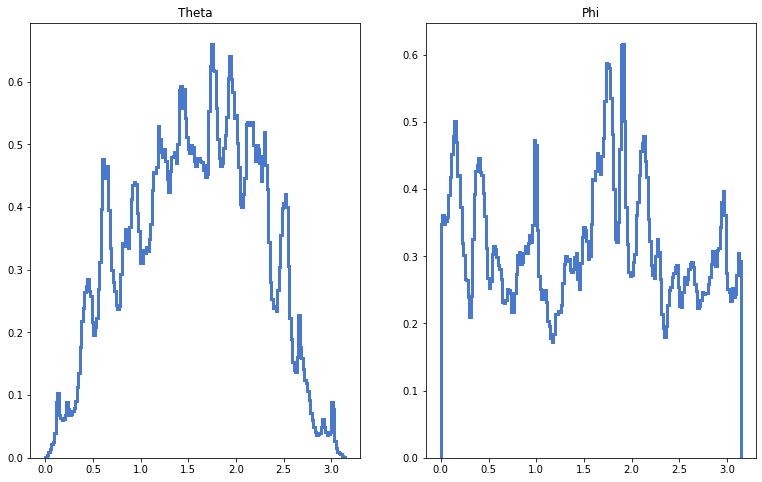

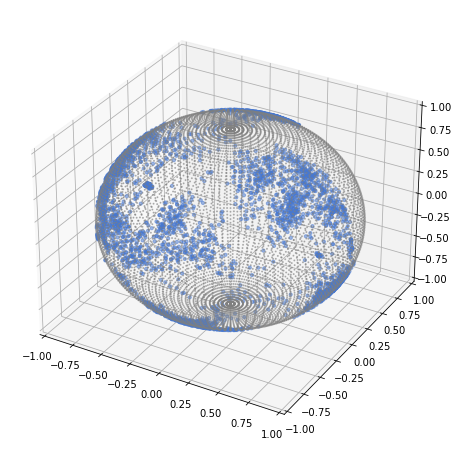

In [329]:
%time hc_radial = hcecp.hessian_cecp3d(burst_stack, 3, with_plot=True)
hc_radial

array([[0.76341052, 0.42834804],
       [0.7589777 , 0.3882735 ],
       [0.73744575, 0.35196043],
       [0.73375208, 0.33613445],
       [0.76102768, 0.31825791]])

In [157]:
trails_stack = make_trails_stack(test_stack.shape)

In [159]:
w = napari.view_image(trails_stack, ndisplay=3)

In [162]:
pts = w.layers[1]

In [169]:
pts.data

array([[111.        , 127.50000705, 125.56194602]])

(0.6958124046450762, 0.36928614527494547)

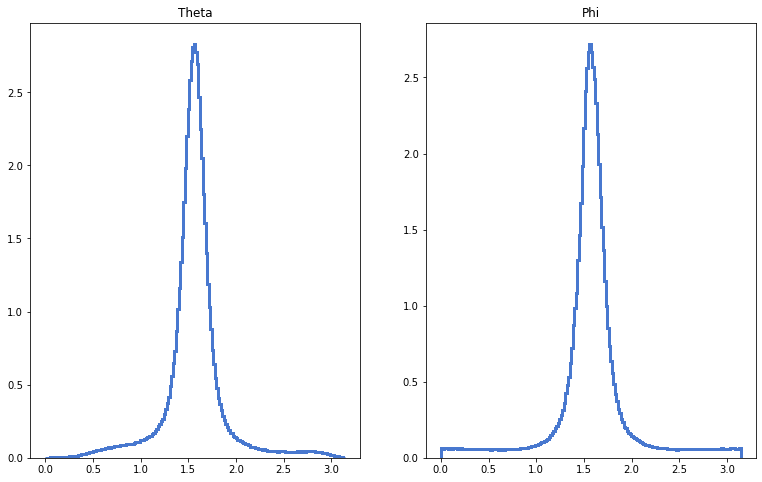

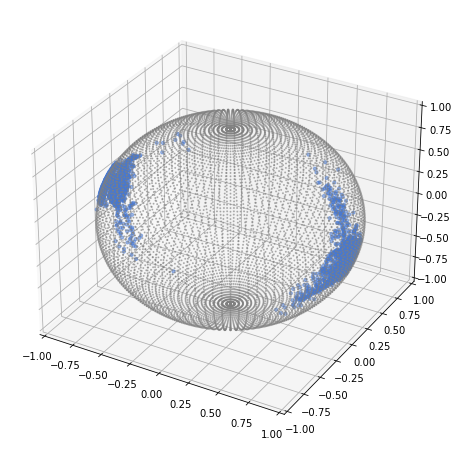

In [119]:
hessian_cecp3d(trails_stack, 3, with_plot=True,j=0)

(0.9009465745859434, 0.23938951779314815)

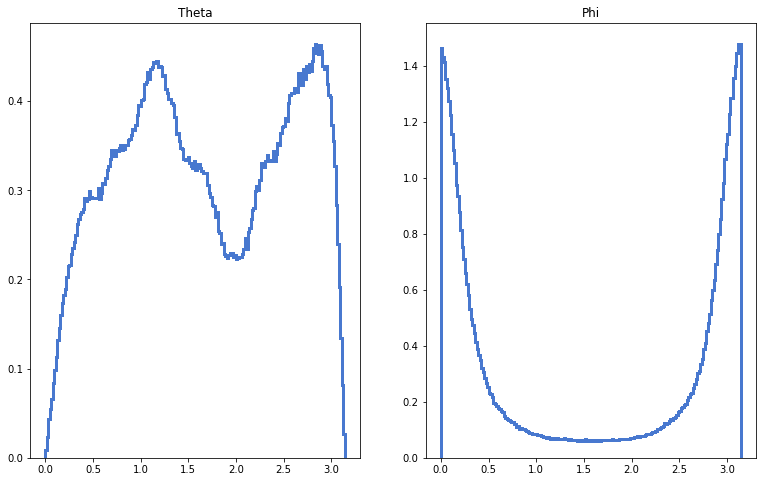

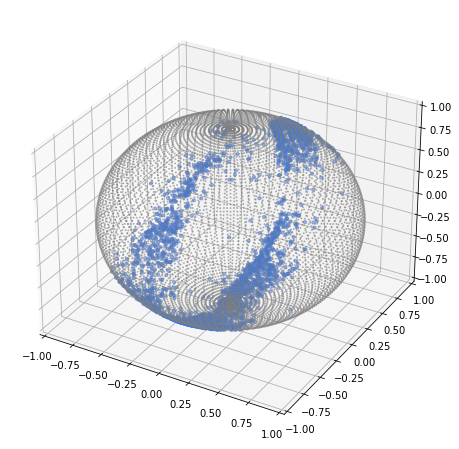

In [120]:
hessian_cecp3d(trails_stack, 3, with_plot=True,j=-1)

In [121]:
trails_stack = make_trails_stack(test_stack.shape, random_weight=0,)
napari.view_image(trails_stack, ndisplay=3)

(0.36958974044841053, 0.2771831187999641)

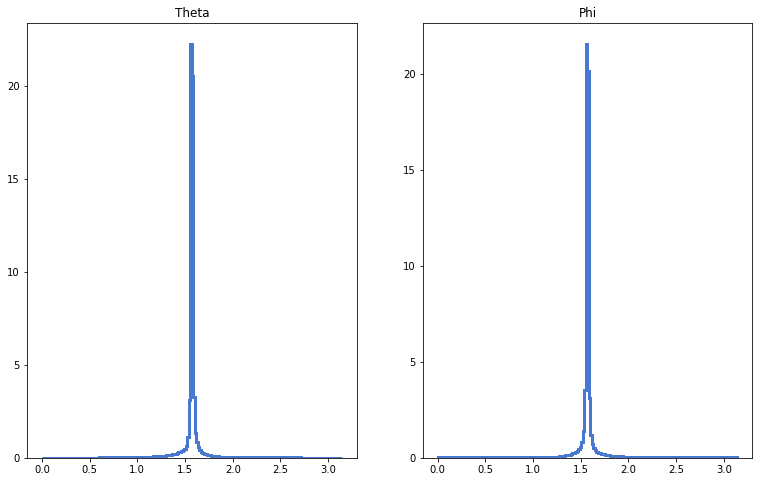

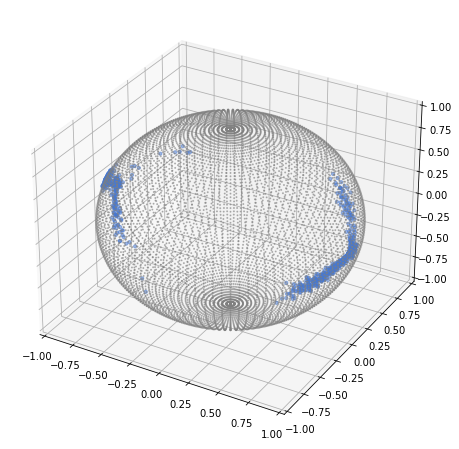

In [122]:
hessian_cecp3d(trails_stack, 3, with_plot=True)

In [123]:
random_weights = linspace(0,1,20)
trail_cecps = array([hessian_cecp3d(make_trails_stack(test_stack.shape,random_weight=rw),sigma=3) for rw in tqdm(random_weights)])

In [124]:
trail_cecps_out = array([hessian_cecp3d(make_trails_stack(test_stack.shape,random_weight=rw),sigma=3,reverse_weights=True) for rw in tqdm(random_weights)])

In [125]:
trail_cecps

array([[0.38098197, 0.27861412],
       [0.37371678, 0.27826312],
       [0.38930301, 0.28635902],
       [0.40423693, 0.29383681],
       [0.42713802, 0.30409691],
       [0.47082483, 0.32597805],
       [0.50813873, 0.34393928],
       [0.55911211, 0.35844737],
       [0.59993308, 0.37022284],
       [0.66127859, 0.36888496],
       [0.72450243, 0.35362467],
       [0.78980935, 0.32391566],
       [0.86564856, 0.25324366],
       [0.90424841, 0.20395478],
       [0.9349088 , 0.15688633],
       [0.95157092, 0.12687417],
       [0.96033173, 0.11014881],
       [0.96809484, 0.09417948],
       [0.9742771 , 0.07625397],
       [0.97719985, 0.0699469 ]])

In [313]:
# figure(figsize=(12,9))

# plot(hc_env2[:,0],hc_env2[:,1], 'gray',ls=':')

# shared_kw = dict( c=random_weights,cmap=cm.viridis,s=100)

# scatter(trail_cecps[:,0], trail_cecps[:,1],marker='o', label='structures',**shared_kw); 
# scatter(trail_cecps_out[:,0], trail_cecps_out[:,1],marker='+',label='background',linewidths=3, **shared_kw); 
# colorbar()

# legend()
# xlabel("H")
# ylabel('C')

Text(0, 0.5, 'C')

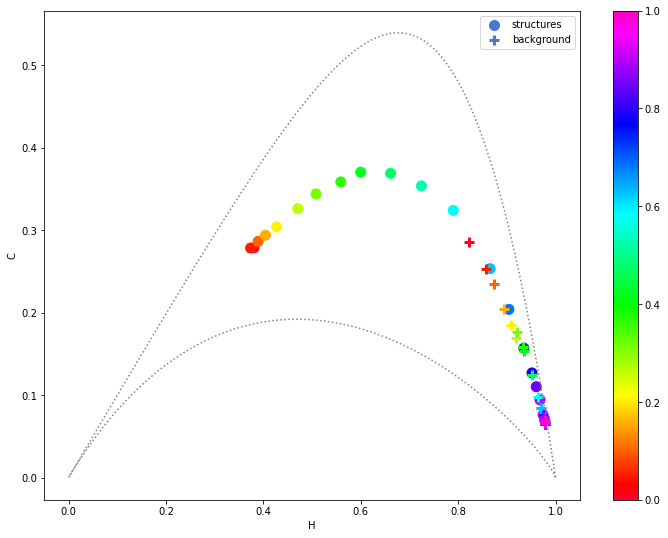

In [126]:
figure(figsize=(12,9))

plot(hc_env2[:,0],hc_env2[:,1], 'gray',ls=':')

shared_kw = dict( c=random_weights,cmap=cm.gist_rainbow,s=100)

scatter(trail_cecps[:,0], trail_cecps[:,1],marker='o', label='structures',**shared_kw); 
scatter(trail_cecps_out[:,0], trail_cecps_out[:,1],marker='+',label='background',linewidths=3, **shared_kw); 
colorbar()

legend()
xlabel("H")
ylabel('C')

In [314]:
rw_stacks = [make_trails_stack(test_stack.shape,random_weight=rw) for rw in (0.05, 0.5, 0.95)]

In [318]:
w = napari.view_image(array(rw_stacks), ndisplay=3)

In [322]:
w.screenshot('outputs/trails-0.95rw.png');

(0.3773054185959541, 0.2790447981261794)

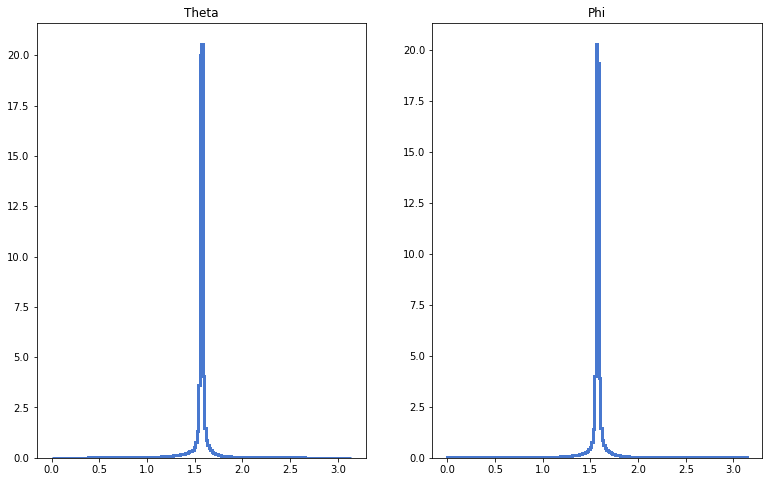

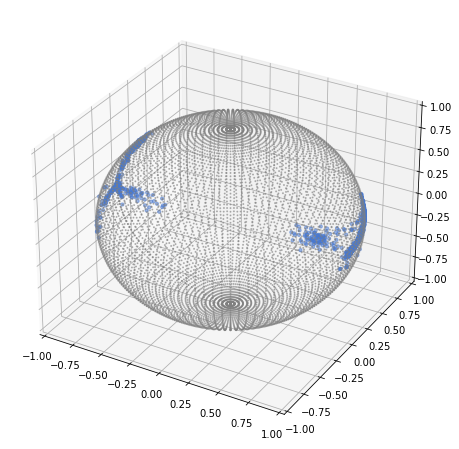

In [323]:
hessian_cecp3d(rw_stacks[0], 3, with_plot=True,j=0)

(0.6884065308269357, 0.36855091173148646)

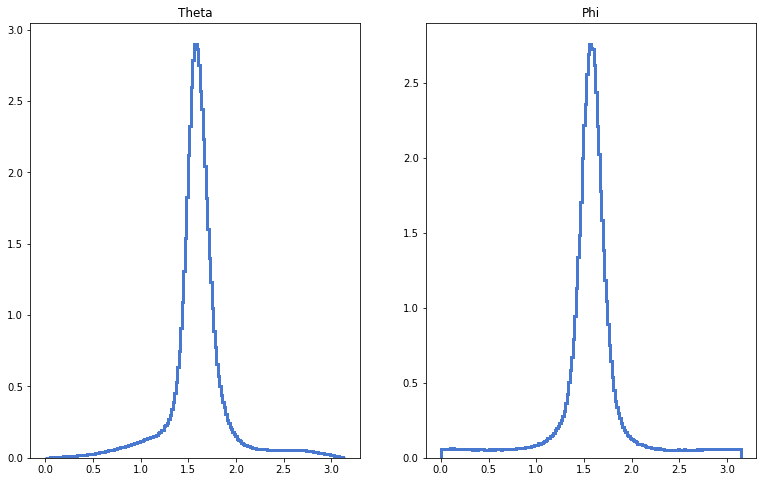

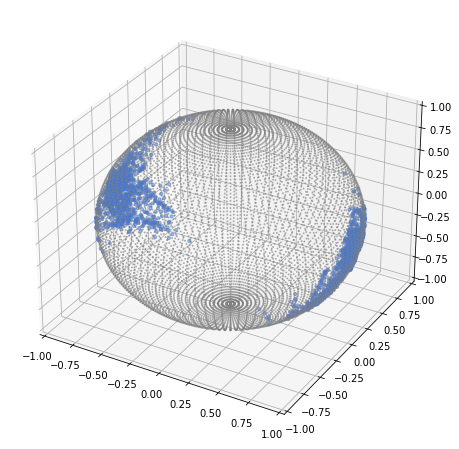

In [326]:
hessian_cecp3d(rw_stacks[1], 3, with_plot=True,j=0)

(0.9724178553736699, 0.08136579337615076)

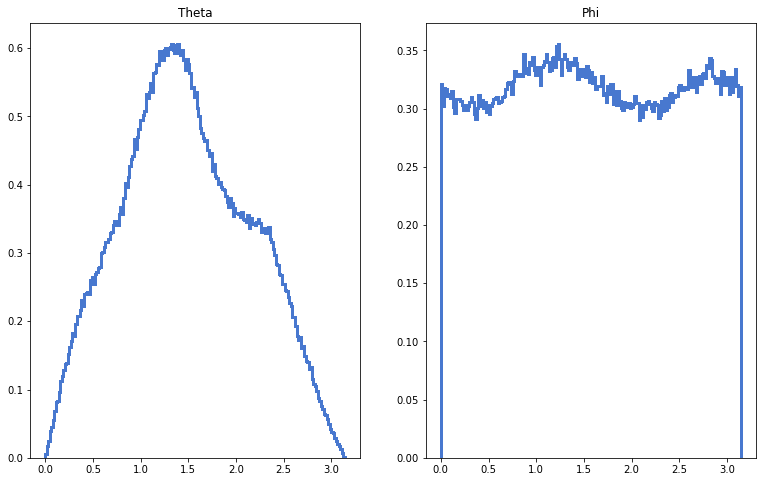

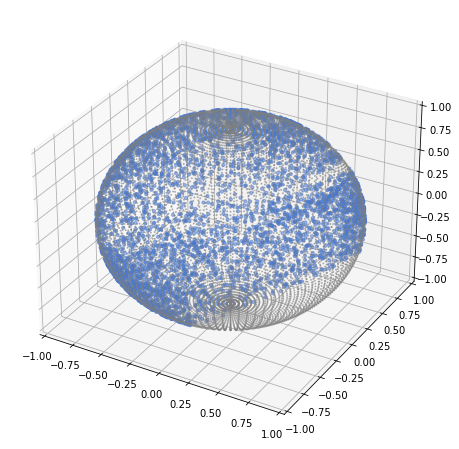

In [327]:
hessian_cecp3d(rw_stacks[2], 3, with_plot=True,j=0)

## Local complexity test

In [30]:
from importlib import reload

In [216]:
import hessian_cecp as hcecp

In [217]:
reload(hcecp)

<module 'hessian_cecp' from '/home/brazhe/yandex-disk/dev/notebooks/astrocyte-morphology-and-networks/hessian_cecp.py'>

In [223]:
#%time trails_stack = make_trails_stack(test_stack.shape, random_weight=0.25)

CPU times: user 2.02 s, sys: 162 ms, total: 2.18 s
Wall time: 2.18 s


In [50]:
#stackz = test_stack
#stackz = test_stack_rot
#stackz = stack_caustic
#stackz = trails_stack
stackz = burst_stack

In [58]:
%time stackz_sato = hcecp.percentile_rescale(hcecp.sato3d(stackz,3, return_vectors=False))

CPU times: user 29.4 s, sys: 12.8 s, total: 42.2 s
Wall time: 42.4 s


In [277]:
w = napari.view_image(stackz, ndisplay=3)
w.add_image(stackz_sato)

<Image layer 'stackz_sato' at 0x7fea5dc5fd30>

In [295]:
patch_size=24
patch_overlap = 12

In [296]:
%time hc_acc = hcecp.hessian_cecp3d(stackz, 1.5, spatial_binning=patch_size,spatial_overlap=patch_overlap,verbose=True)


CPU times: user 56.2 s, sys: 7 s, total: 1min 3s
Wall time: 1min 3s


In [297]:
hc_mf = np.sum(hc_acc[:,:2]*hc_acc[:,2][:,None], axis=0)
hc_mf

array([0.75991486, 0.2923484 ])

In [290]:
cstack = np.zeros(stackz.shape)
hstack = np.zeros(stackz.shape)

windows = hcecp.make_grid(stackz.shape, patch_size, patch_overlap)
counts = np.zeros(stackz.shape,int)

for w, hc in zip(windows, hc_acc):
    hstack[w] += hc[0]
    cstack[w] += hc[1]
    counts[w] += 1
    
cstack = cstack/(1e-5 + counts)
hstack = hstack/(1e-5 + counts)

In [291]:
w = napari.view_image(stackz, ndisplay=3,colormap='red',gamma=0.75)
w.add_image(cstack,blending='additive',colormap='green',opacity=0.5)
#w.add_image(hstack,blending='additive',colormap='gray_r')

<Image layer 'cstack' at 0x7fea5dbb0fd0>

In [286]:
w.screenshot('outputs/radial-stack-with-patch-complexity-overlay-small-patches.png');

In [283]:
# ax = hcecp.prep_hc_axes(50*50)
# ax.scatter(hc_acc[:,0],hc_acc[:,1], s=2, c=[stackz[w].mean() for w in windows],alpha=0.5,cmap='Reds')

Text(0.5, 1.0, 'patch size 9 px')

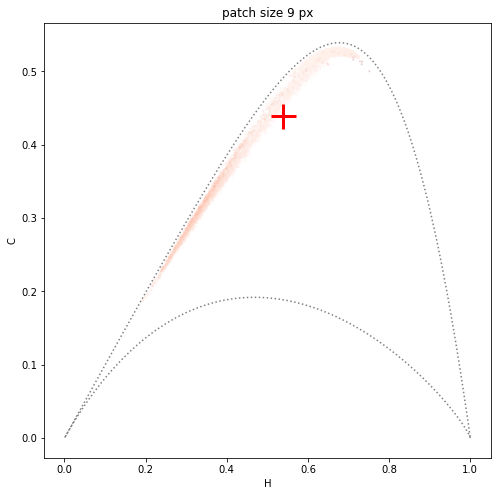

In [294]:
f, ax = subplots(1,1,figsize=(8,8))
ax = hcecp.prep_hc_axes(50*50, ax)
ax.scatter(hc_acc[:,0],hc_acc[:,1], s=2, c=hc_acc[:,2],alpha=0.1,cmap='Reds')
plot(hc_mf[0],hc_mf[1],'r+',ms=25,mew=3,)
title('patch size 9 px')

Text(0.5, 1.0, 'patch size 24 px')

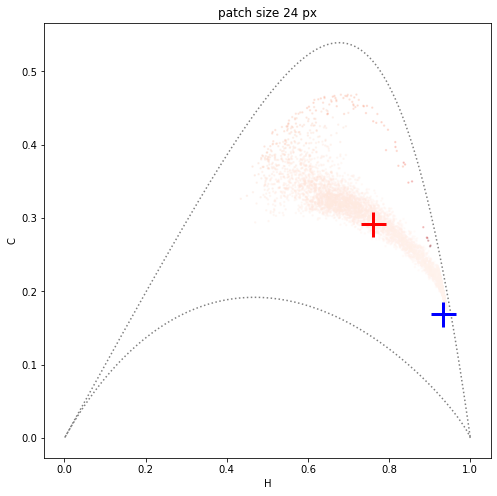

In [330]:
f, ax = subplots(1,1,figsize=(8,8))
ax = hcecp.prep_hc_axes(50*50, ax)
ax.scatter(hc_acc[:,0],hc_acc[:,1], s=2, c=hc_acc[:,2],alpha=0.2,cmap='Reds')
plot(hc_mf[0],hc_mf[1],'r+',ms=25,mew=3,)
plot(hc_radial[0],hc_radial[1],'b+',ms=25,mew=3,)
title('patch size 24 px')

In [299]:
#w = napari.view_image(trails_stack, ndisplay=3)

In [300]:
#%time res_trails = {ps: get_ms_complexity(trails_stack, sigmas_new, ps) for ps in tqdm(patch_sizes)}
%time res_radial = {ps: get_ms_complexity(stackz, sigmas_new, ps) for ps in tqdm(patch_sizes)}



CPU times: user 1h 16min 34s, sys: 1h 18min 52s, total: 2h 35min 27s
Wall time: 1h 2min 45s


In [301]:
len(patch_sizes)

5

12 6 3.311
24 7 4.537
48 7 4.537


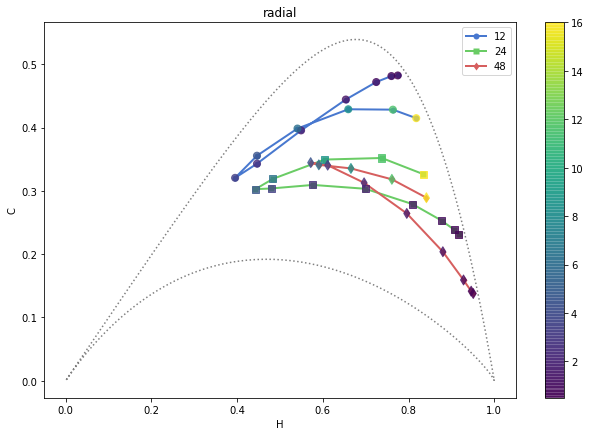

In [343]:
f,ax =  subplots(1,1,figsize=(9,6))
hcecp.prep_hc_axes(50*50, ax=ax)

markers = ['o', 's', 'd', '*', '^']

for k,ps in enumerate(patch_sizes[::2]):
    res =  res_radial[ps]
    m = markers[k]
    ax.plot(res.loc['h'],res.loc['c'],label=ps, ls='-', marker=m,mec='none',  zorder=-1, lw=2);
    h = ax.scatter(res.loc['h'],res.loc['c'],c=res.columns,marker=m,cmap=cm.viridis,alpha=0.75,s=50)
    kmx = argmin(res.loc['h'])
    print(ps, kmx, sigmas_new[kmx])

colorbar(h, ax=ax)
tight_layout()
title('radial')
legend()

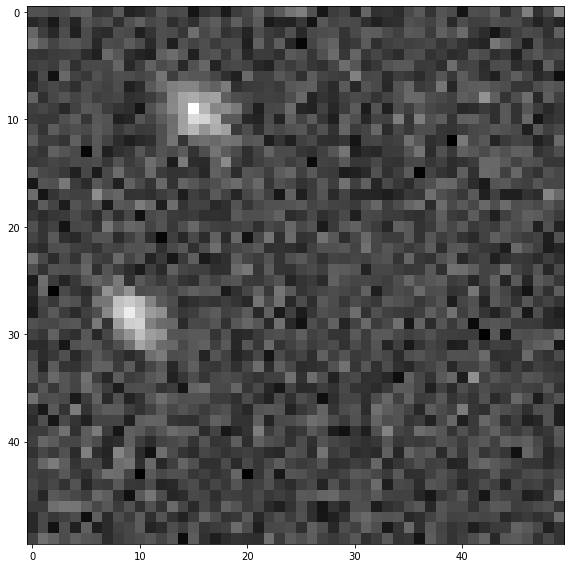

In [338]:
figure(figsize=(8,8))
imshow(burst_stack[0][0:50,0:50])
tight_layout()

In [344]:
for k,ps in enumerate(patch_sizes):
    res =  res_radial[ps]
    kmx = argmin(res.loc['h'])
    print(ps, kmx, sigmas_new[kmx])

12 6 3.311
16 7 4.537
24 7 4.537
32 7 4.537
48 7 4.537


In [341]:
for k,ps in enumerate(patch_sizes):
    res =  res_trails[ps]
    kmx = argmin(res.loc['h'])
    print(ps, kmx, sigmas_new[kmx])

12 5 2.416
16 5 2.416
24 6 3.311
32 6 3.311
48 6 3.311


In [350]:
energies_radial = [np.linalg.norm(hcecp.sato3d(stackz, sigma)*sigma**2) for sigma in tqdm(sigmas_new)]

Text(0, 0.5, 'global norm of sato')

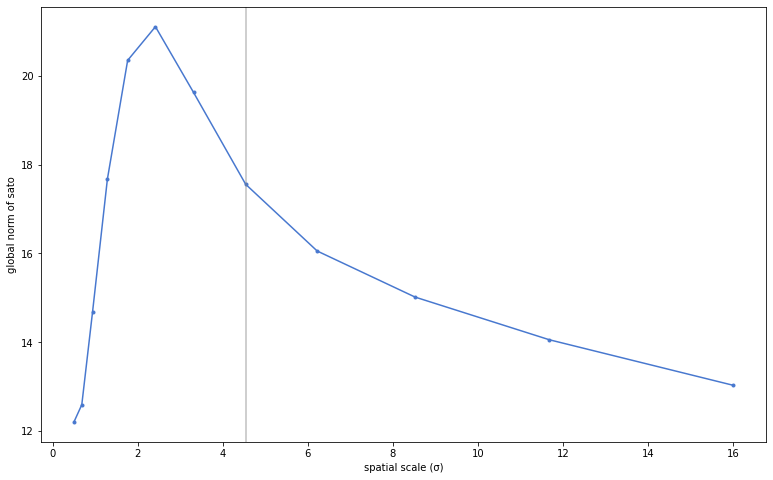

In [357]:
k = argmax(energies_radial)

plot(sigmas_new, energies_radial,'.-')
#axvline(sigmas_new[k], color='m', ls='--')
axvline(sigmas_new[7], color='gray',alpha=0.5)

xlabel('spatial scale (σ)')
ylabel('global norm of sato')

In [356]:
#napari.view_image(stackz)

12 5 2.416
24 6 3.311
48 6 3.311


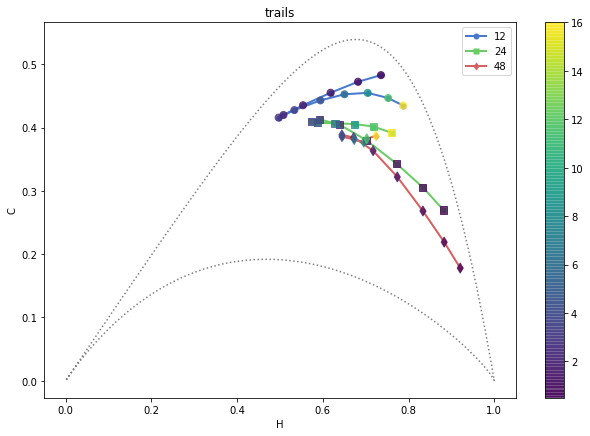

In [332]:
f,ax =  subplots(1,1,figsize=(9,6))
hcecp.prep_hc_axes(50*50, ax=ax)

markers = ['o', 's', 'd', '*', '^']

for k,ps in enumerate(patch_sizes[::2]):
    res =  res_trails[ps]
    m = markers[k]
    ax.plot(res.loc['h'],res.loc['c'],label=ps, ls='-', marker=m,mec='none',  zorder=-1, lw=2);
    h = ax.scatter(res.loc['h'],res.loc['c'],c=res.columns,marker=m,cmap=cm.viridis,alpha=0.75,s=50)
    kmx = argmin(res.loc['h'])
    print(ps, kmx, sigmas_new[kmx])
colorbar(h, ax=ax)
tight_layout()
title('trails')
legend()

In [178]:
sigmas_new[5]

2.416

In [182]:
res_trails[12]

0.500     0.685     0.939     1.287     1.763     2.416     3.311   \
h  0.735647  0.682024  0.618069  0.553692  0.508127  0.496813  0.533553   
c  0.482908  0.472421  0.455049  0.435303  0.419928  0.415746  0.427666   

     4.537     6.218     8.520     11.676    16.000  
h  0.594304  0.650415  0.704474  0.752391  0.786991  
c  0.442953  0.452634  0.454884  0.446740  0.434836

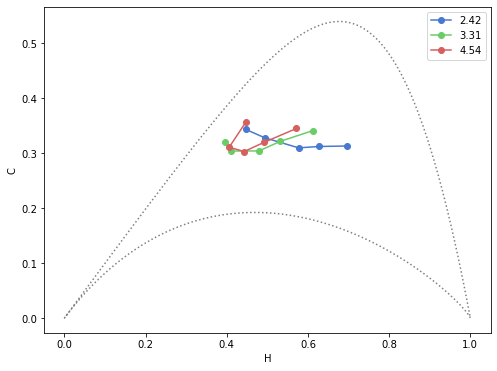

In [346]:
f,ax =  subplots(1,1,figsize=(8,6))
hcecp.prep_hc_axes(50*50, ax=ax)


for sigma in sigmas_new[5:8]:
    hc = array([res_radial[ps][sigma] for ps in res_trails])
    plot(hc[:,0],hc[:,1],'o-',label='%2.2f'%sigma)
legend()

In [51]:
#@jit
def sample_sphere_mgrid(stack, center, rmin, rmax):
    sh = stack.shape
    out = np.zeros_like(stack)
    Z,X,Y = np.mgrid[0:sh[0],0:sh[1],0:sh[2]]
    rr = ((Z - center[0])**2 + (X-center[1])**2 + (Y-center[2])**2)**0.5
    cond = (rr >= rmin) & (rr<rmax)
    out[cond] = stack[cond]
    return out    

from numba import jit

@jit
def sample_sphere3d(stack, center, rmin, rmax):
    sh = stack.shape
    out = np.zeros(sh)
    zc, rc, cc = center
    for z in range(sh[0]):
        for r in range(sh[1]):
            for c in range(sh[2]):
                rr = ((z-zc)**2 + (r-rc)**2 + (c-cc)**2)**0.5
                if rmin <= rr < rmax:
                    out[z,r,c] = stack[z,r,c]
    return out

@jit(nopython=True)
#unfinished
def my_unravel_index(j, shape):
    ndim = len(shape)
    out = np.zeros(ndim)
    for i in range(ndim):
        out[i] = j

    
#@jit
#unfinished
def sample_sphere_nd(stack, center, rmin, rmax):
    sh = stack.shape
    ndim = len(sh)
    out = np.zeros(stack.size)
    stack_flat = stack.reshape(stack.size)
    
    #zc, rc, cc = center
    for i in range(stack.size):
        coords = np.unravel_index(i, sh)
        rr = 0
        for j in arange(ndim):
            rr += (coords[j]-center[j])**2
        rr = rr**0.5
        if rmin <= rr < rmax:
            out[i] = stack_flat[i]
    return out


import os
def ensure_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)
        
        
def make_border_stack(shape):        
    frame_stack = np.zeros(shape, bool)

    frame_stack[:,0,0] = frame_stack[:,-1,-1] = 1
    frame_stack[0,:,0] = frame_stack[-1,:,-1] = 1
    frame_stack[0,0,:] = frame_stack[-1,-1,:] = 1

    frame_stack[:,0,-1] = frame_stack[:,-1,0] = 1
    frame_stack[0,:,-1] = frame_stack[-1,:,0] = 1
    frame_stack[-1,0,:] = frame_stack[0,-1,:] = 1
    
    return frame_stack

In [404]:
napari.view_image(stackz)

In [405]:
#np.ravel?

In [59]:


#%time x = sample_sphere_mgrid(stackz, x0, 50,51)
%time x = sample_sphere3d(stackz_sato, x0, 50,51)
#%time x = sample_sphere_nd(stackz, x0, 50,51)


CPU times: user 30.6 ms, sys: 29.9 ms, total: 60.5 ms
Wall time: 60.3 ms


In [60]:
frame_stack = make_border_stack(stackz.shape)

In [61]:
w = napari.view_image(stackz_sato, ndisplay=3)
w.add_image(x, blending='additive', colormap='magenta')
w.add_image(frame_stack, blending='additive',colormap='cyan')

<Image layer 'frame_stack' at 0x7fdfb6ea5eb0>

[]

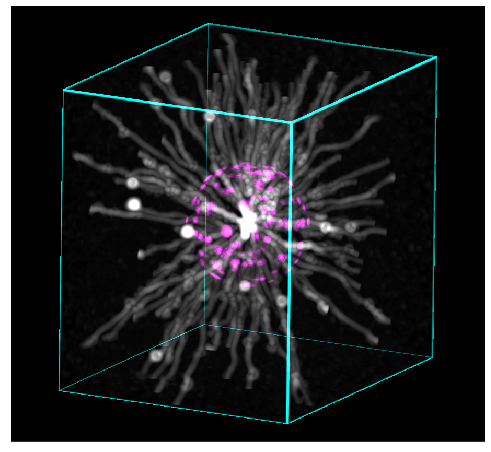

In [65]:
scr = w.screenshot('outputs/sphere-surface-cut.png')
imshow(scr)
setp(gca(), xticks=[],yticks=[])

## Turbosnails update

In [641]:
%time sato,Vf = sato3d(test_stack_rot, 3, return_vectors=True)

CPU times: user 50.2 s, sys: 9.01 s, total: 59.2 s
Wall time: 59.4 s


In [642]:
Vfj = Vf[...,0][...,::-1] # vectors pointing along structures, but I don't know why I should reverse the ordering

In [643]:
sato_n = percentile_rescale(sato)

In [644]:
mask = sato_n == 1

In [645]:
starts = permutation(array(where(mask)).T)[:min(sum(mask),10000)]

In [646]:
len(starts)

10000

In [668]:
field = 5.0*Vfj*sato_n[:,:,:,None]
minus_field = -field

In [669]:
Nparticles = 100

trails = np.zeros(test_stack_rot.shape)

#starts = [tuple(randint(n) for n in trails.shape) for i in range(Nparticles)]
kw = dict(dt=0.1, T=1000, m=10, gamma_speed=0.5,wrap_bounds=False)

for x0 in tqdm(starts):
    make_trajectory3d(x0, field, trails, **kw)
    make_trajectory3d(x0, minus_field, trails, **kw)

In [670]:
sum(trails >0)

191842

In [671]:
trails.max()

7.686819938444914

In [672]:
w = napari.view_image(sato_n, ndisplay=3, blending='additive', opacity=0.15)
#w.add_image(percentile_rescale(ndi.gaussian_filter(trails>0,1.5)))
w.add_image(log(1+clip(trails,0,100)), colormap='red', blending='additive')

<Image layer 'Image' at 0x7f78fd69a730>

100

In [691]:

@numba.jit
def collect_trails(field, mask=None, m=10, mag_th=0.05, dt=0.25, friction=0.05, T=1000):
    sh = field.shape[:-1]
    trails = np.zeros(sh)
    mag = np.sum(field**2,axis=-1)**0.5
    if mask is None:
        mask = mag > mag_th
    for z in range(sh[0]):
        for r in range(sh[1]):
            for c in range(sh[2]):
                if mask[z,r,c]:
                    make_trajectory3d(np.array([z,r,c]), field, trails, m=m, dt=dt,friction=friction, T=T)
    return trails
    
    
def turbosnail_vesselness(stack, sigma, amp=5, start_threshold=0.99, mask=None, **kwargs):
    sato, Vf = sato3d(stack, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)
    Vfj = Vf[...,0][...,::-1]
    weights = percentile_rescale(sato)
    #mask = (lam[...,0] < 0) & ((lam[...,1] <= 0) | (lam[...,1] < np.abs(lam[...,0])/0.5))
    #weights = percentile_rescale(np.abs(lam[...,0]))*mask
    if mask is None:
        mask = weights > start_threshold
    field = amp*Vfj*weights[...,np.newaxis]
    trails = 0.5*(collect_trails(field,mask, **kwargs) + collect_trails(-field,mask,**kwargs))
    return trails 

In [689]:
#%time trails = collect_trails(field,mask,m=10,dt=0.1)

In [690]:
%time trails = turbosnail_vesselness(test_stack_rot, 3)

CPU times: user 2min 13s, sys: 8.87 s, total: 2min 22s
Wall time: 2min 22s


In [685]:
napari.view_image(log(1 + trails))

In [693]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'